In [128]:
# =========================
# Standard library
# =========================
import time

# =========================
# Third-party libraries
# =========================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import seaborn as sns
import shap

import scipy.stats as ss
from scipy.stats import loguniform, randint, uniform

# =========================
# scikit-learn
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# =========================
# Gradient boosting & Bayesian opt
# =========================
from xgboost import XGBClassifier
from hyperopt import Trials, STATUS_OK, fmin, hp, tpe

In [63]:
df = pd.read_csv('data/bank-additional-full.csv.zip', sep=';')

In [64]:
df.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


# Input variables:

## Bank client data:

- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

## Related with the last contact of the current campaign:<br>
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

## Social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

# Output variable (desired target):<br>
- y - has the client subscribed a term deposit? (binary: 'yes','no')


In [65]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [66]:
df.shape

(41188, 21)

# Check Unique values of all the column

In [67]:
for i in df.columns:
    print(i)
    print(df[i].unique())
    print('---' * 20)

age
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
------------------------------------------------------------
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
------------------------------------------------------------
marital
['married' 'single' 'divorced' 'unknown']
------------------------------------------------------------
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
------------------------------------------------------------
default
['no' 'unknown' 'yes']
------------------------------------------------------------
housing
['no' 'yes' 'unknown']
------------------------------------------------------------


# List of numeric columns

In [68]:
numerical_cols = list(df.select_dtypes(exclude=['object']))
numerical_cols

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

# Check Target Variable

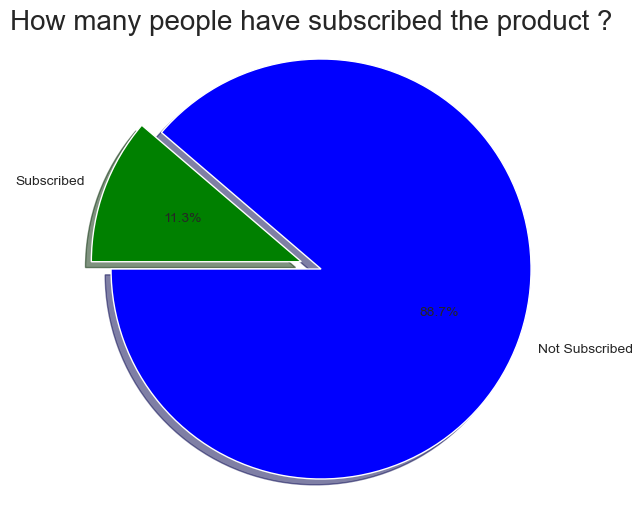

In [69]:
labels = 'Not Subscribed', 'Subscribed'
sizes = df.y.value_counts()
colors = ['blue', 'green']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("How many people have subscribed the product ?", fontsize=20)
plt.plot()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.show()

### Only 11.3% people have subscribed to product

# List of Categorical columns

In [70]:
category_cols = list(df.select_dtypes(include=['object']))
category_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

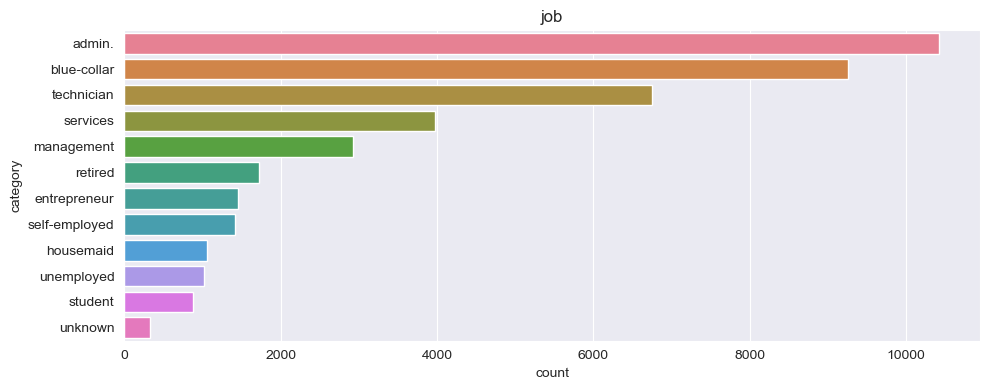

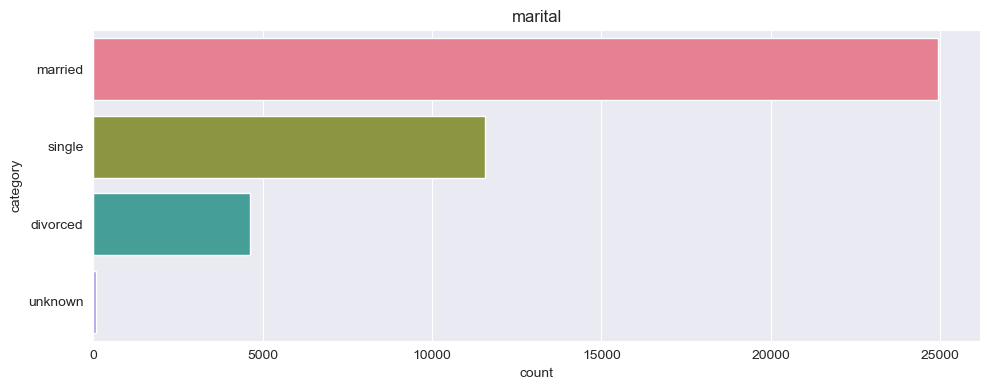

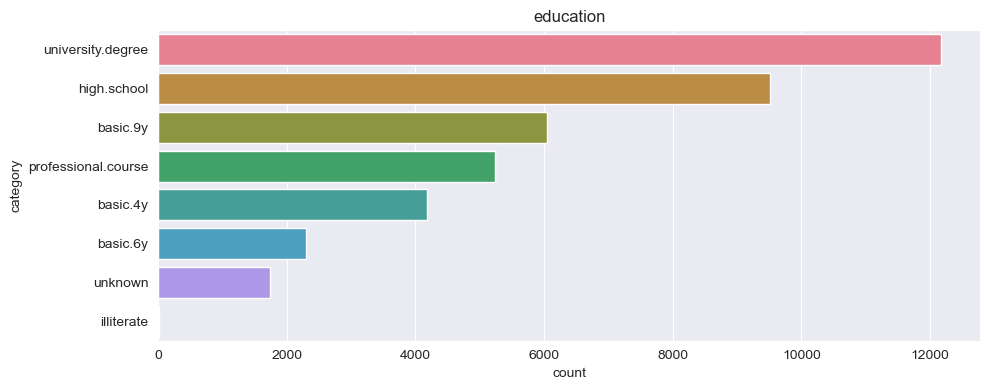

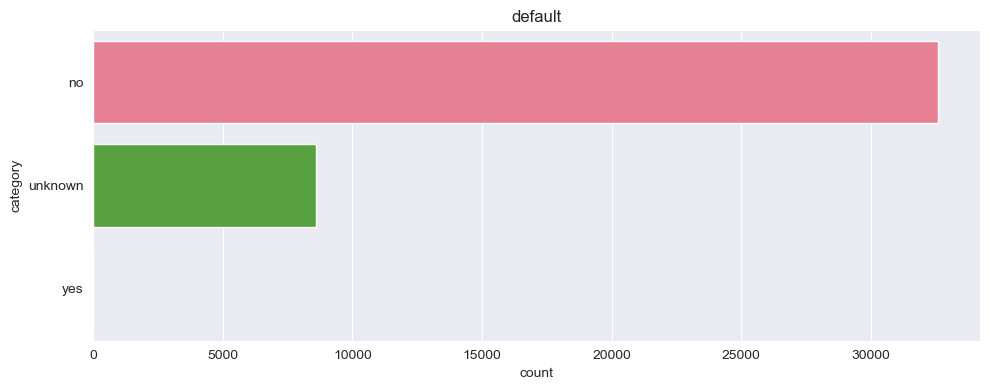

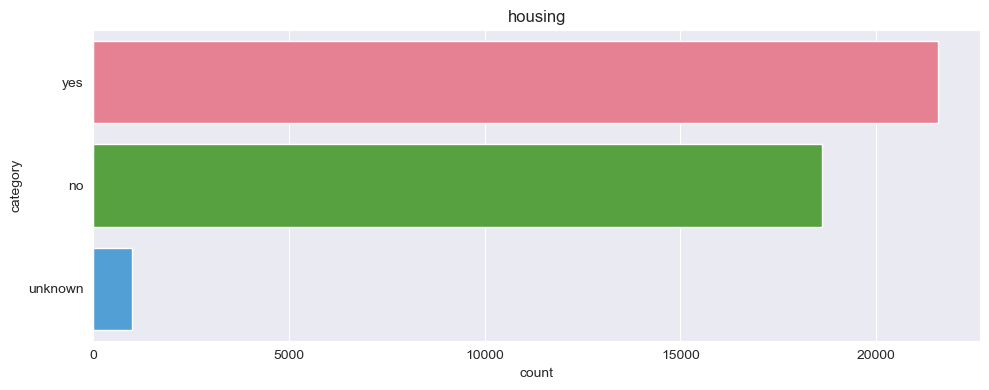

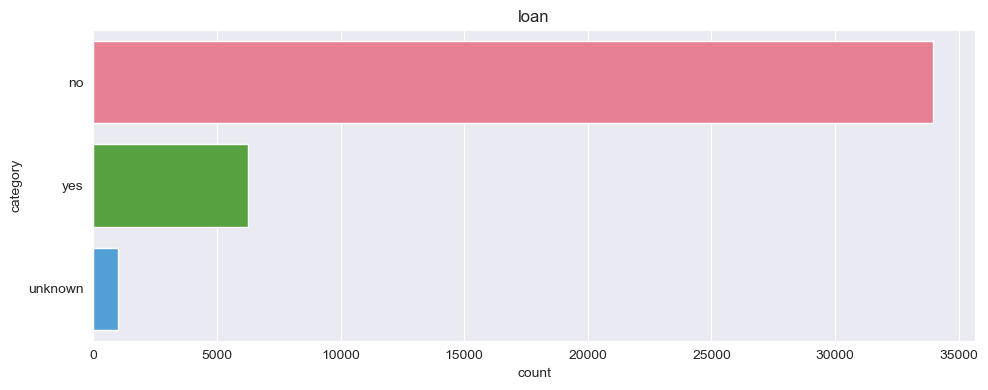

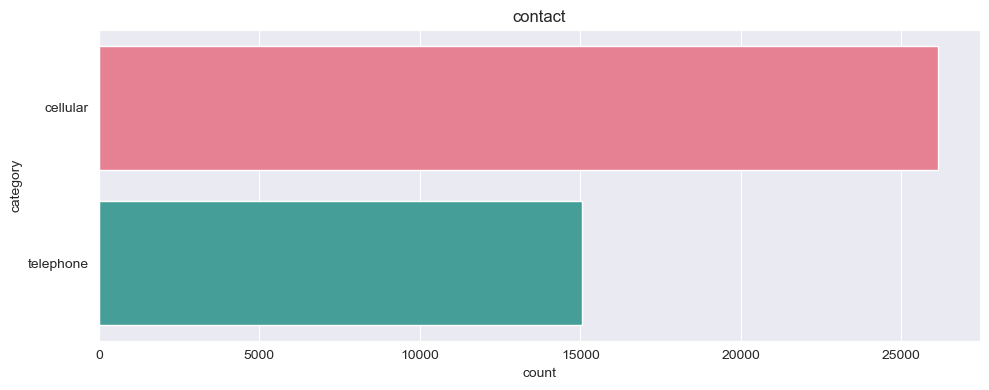

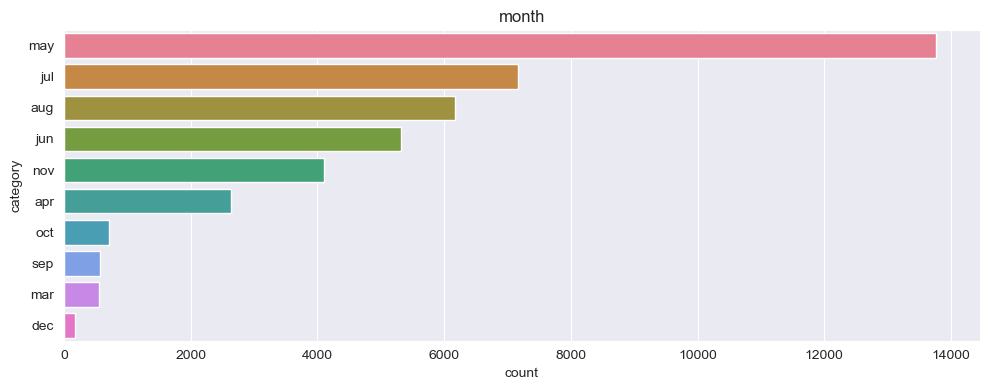

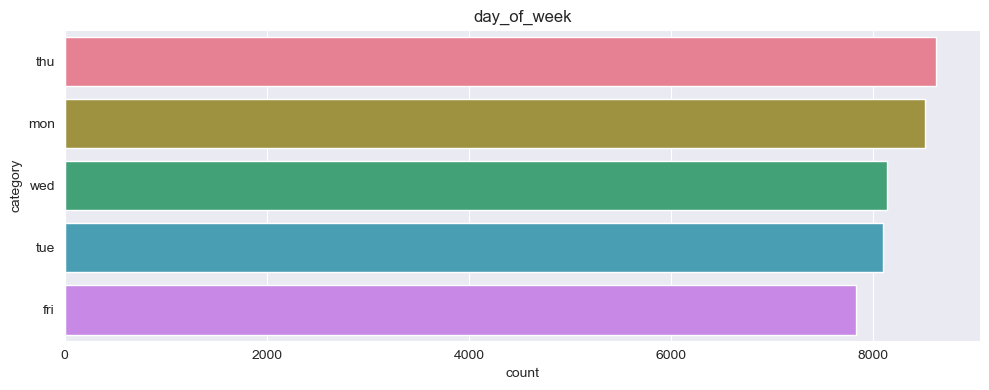

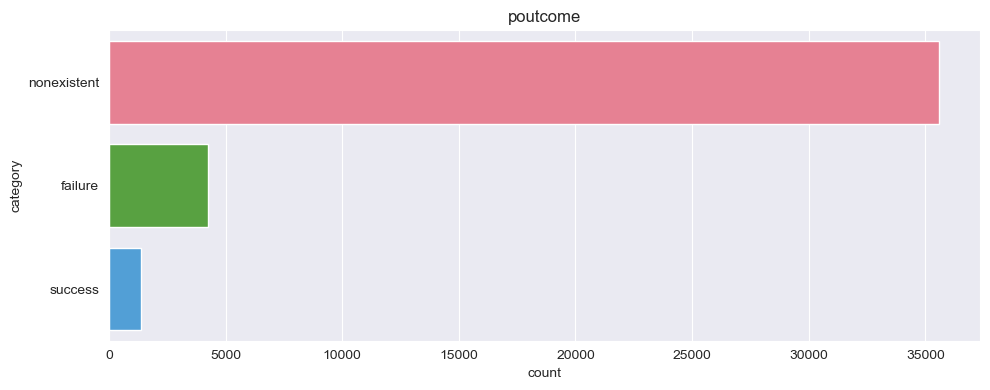

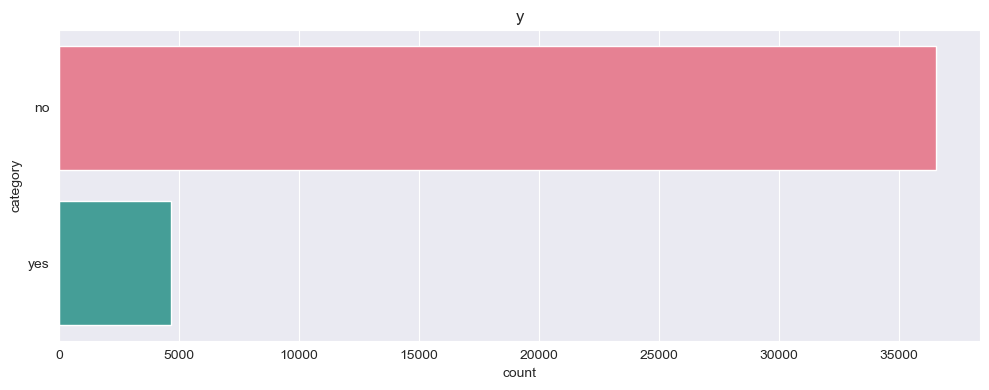

In [71]:
for col in category_cols:
    plt.figure(figsize=(10, 4))
    counts = df[col].value_counts().reset_index()
    counts.columns = ["category", "count"]

    sns.barplot(
        data=counts,
        x="count",
        y="category",
        hue="category",
        dodge=False,
        palette="husl",
        legend=False
    )
    plt.title(col)
    plt.tight_layout()

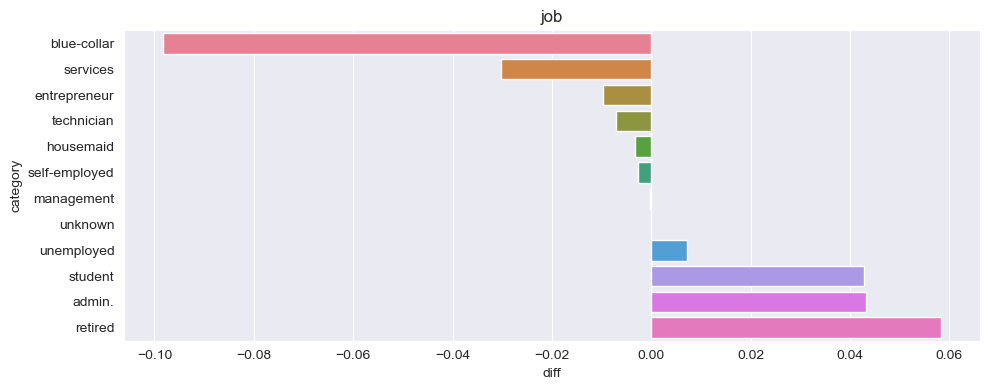

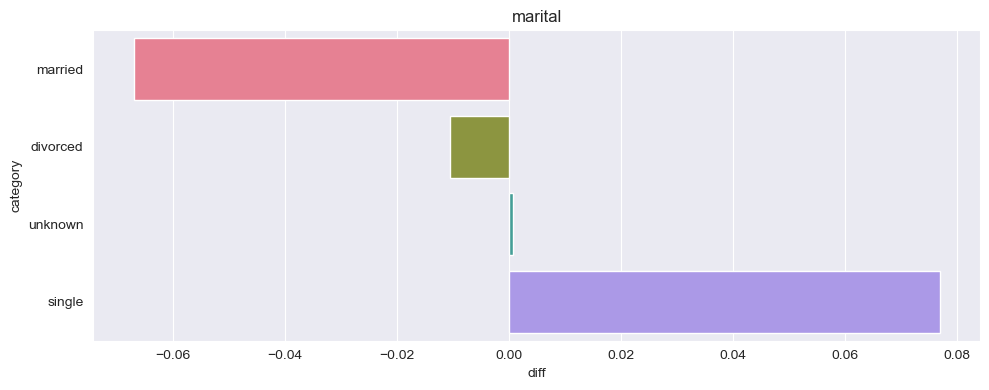

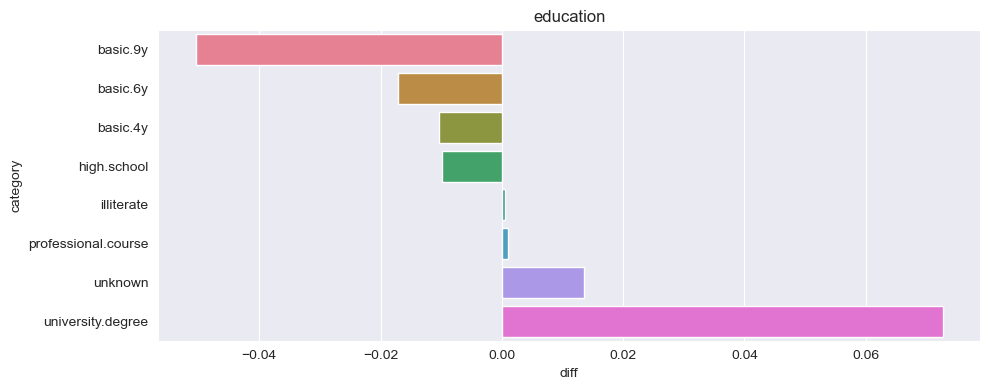

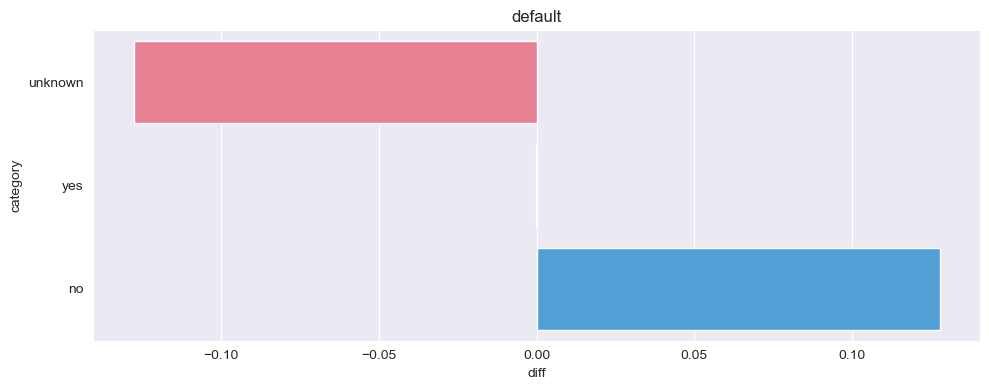

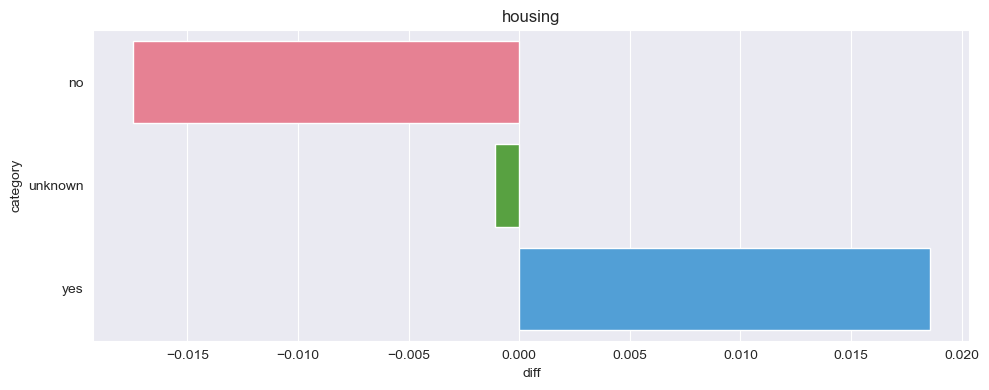

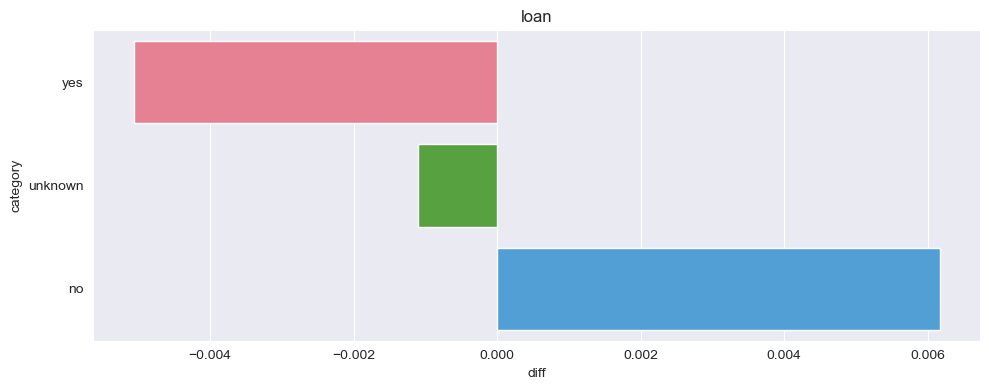

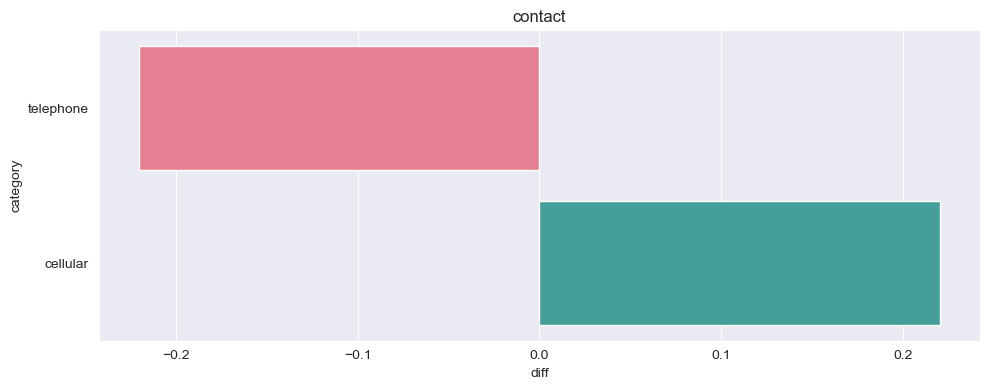

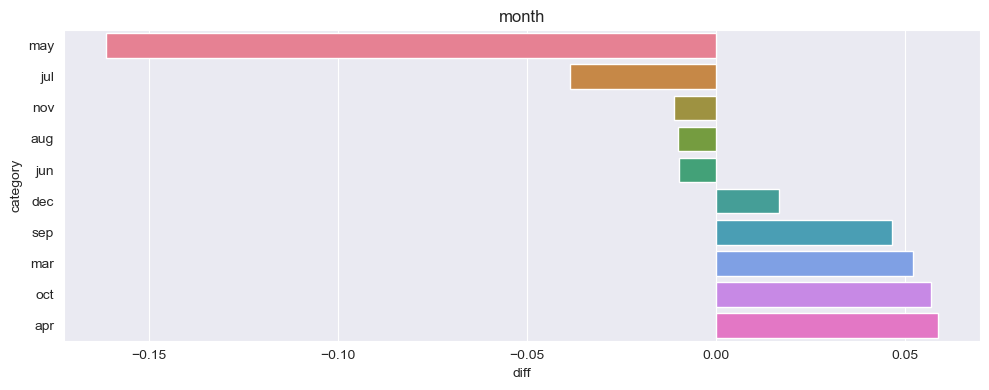

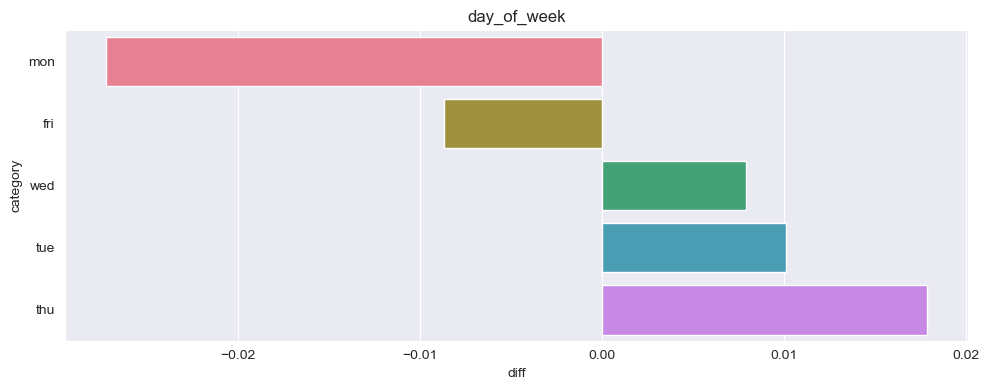

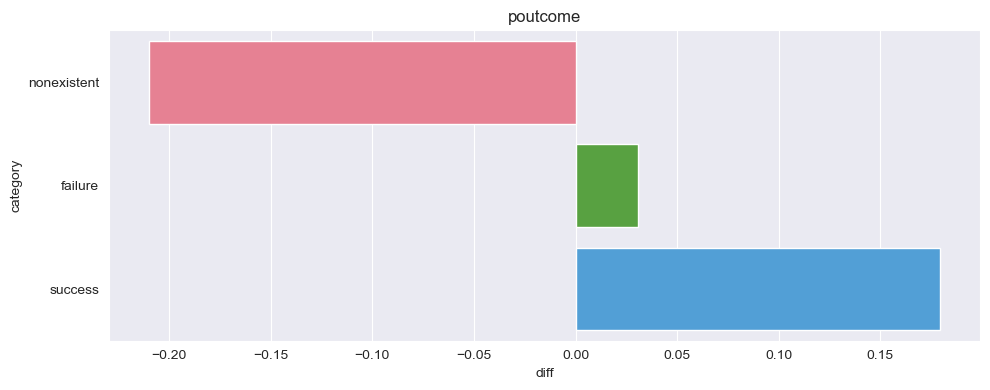

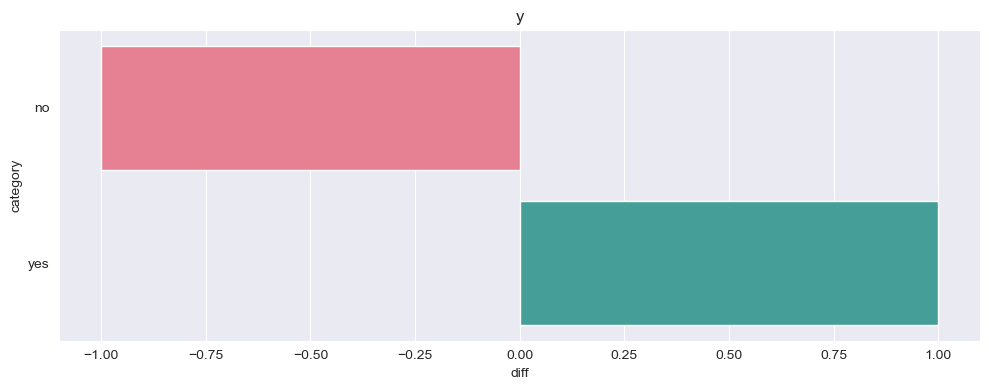

In [72]:
for col in category_cols:
    plt.figure(figsize=(10, 4))
    pos_counts = df.loc[df.y == 'yes', col].value_counts()
    neg_counts = df.loc[df.y == 'no', col].value_counts()

    cats = pos_counts.index.union(neg_counts.index)
    freq_pos = (df.y == 'yes').sum()
    freq_neg = (df.y == 'no').sum()

    pos_d = pos_counts.to_dict()
    neg_d = neg_counts.to_dict()

    diffs = [pos_d.get(k, 0) / freq_pos - neg_d.get(k, 0) / freq_neg for k in cats]

    plot_df = pd.DataFrame({'category': cats, 'diff': diffs}).sort_values('diff', ascending=True)

    sns.barplot(data=plot_df, x='diff', y='category', hue='category', dodge=False, palette='husl', legend=False)
    plt.title(col)
    plt.tight_layout()

## Summary: Missing Values Exploration

The analysis of missing values (represented as `"unknown"`) across categorical features shows that:

- The **`default`** feature has very few missing entries compared to the dataset size, indicating it is not a critical issue.
- Features like **`housing`** and **`loan`** have more frequent `"unknown"` values, but they are still distributed in a way that does not dominate the dataset.
- For **`job`** and **`education`**, `"unknown"` values are present but relatively rare compared to other categories.

Overall, the missing values are not concentrated in one variable and do not suggest a severe data quality issue, though they could slightly bias analysis if left untreated.


# Missing Value /Unknown value

In [73]:
mode_default = df['default'].mode()[0]
mode_housing = df['housing'].mode()[0]
mode_loan = df['loan'].mode()[0]
mean_pdays = df.loc[df['pdays'] < 999, 'pdays'].mean()

df = df.assign(
    default=df['default'].mask(df['default'] == 'unknown', mode_default),
    housing=df['housing'].mask(df['housing'] == 'unknown', mode_housing),
    loan=df['loan'].mask(df['loan'] == 'unknown', mode_loan),
    y=df['y'].eq('yes').astype('int8'),
    pdays=df['pdays'].where(df['pdays'] < 999, mean_pdays)
)

df.loc[(df['age'] > 60) & (df['job'] == 'unknown'), 'job'] = 'retired'
df.loc[(df['education'] == 'unknown') & (df['job'] == 'management'), 'education'] = 'university.degree'
df.loc[(df['education'] == 'unknown') & (df['job'] == 'services'), 'education'] = 'high.school'
df.loc[(df['education'] == 'unknown') & (df['job'] == 'housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education'].isin(['basic.4y', 'basic.6y', 'basic.9y'])), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education'] == 'professional.course'), 'job'] = 'technician'


In [74]:
for col in ["job", "marital", "education"]:
    mode_value = df.loc[df[col] != "unknown", col].mode()[0]
    df[col] = df[col].replace("unknown", mode_value)

(df == 'unknown').sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

# Feature Relationship Analysis

<Axes: >

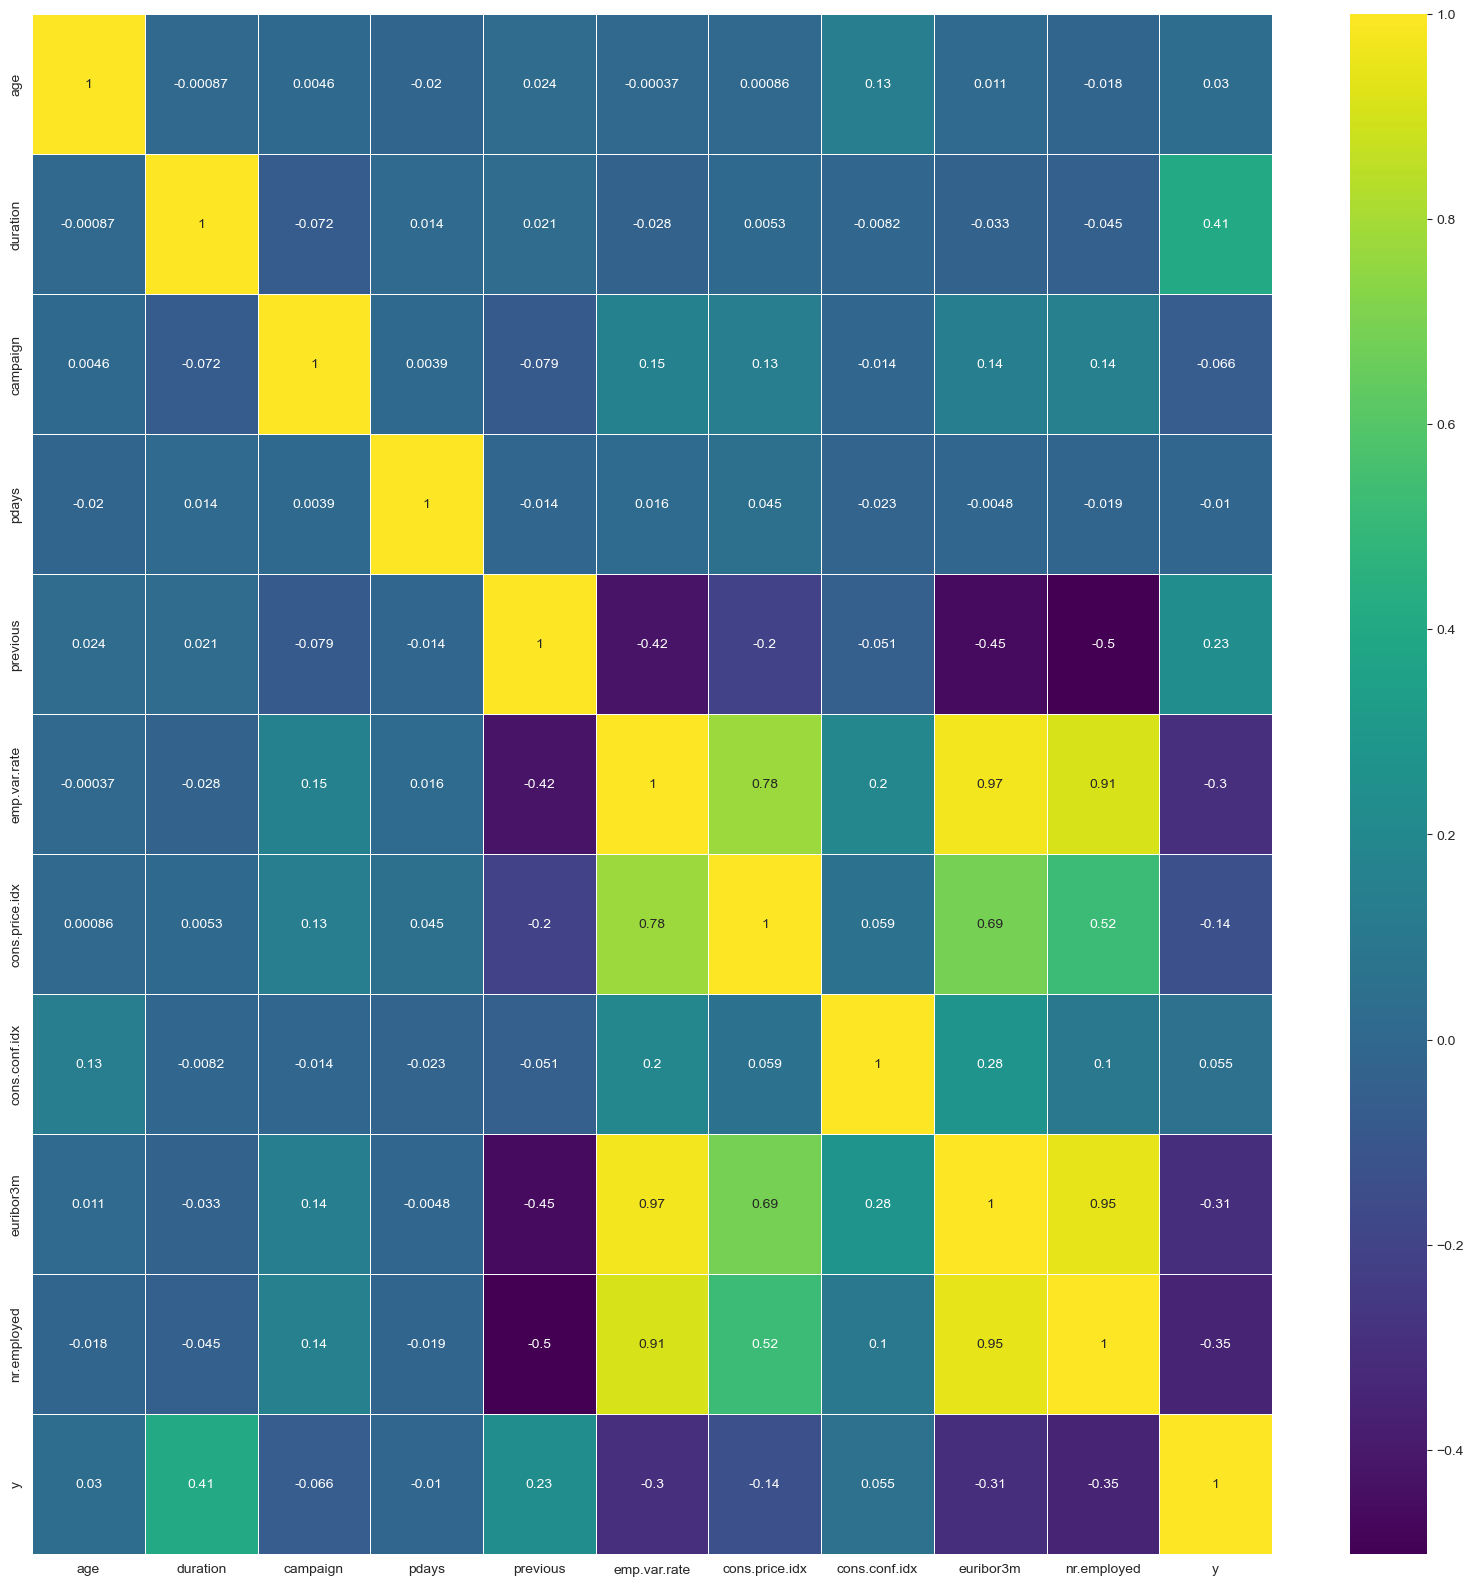

In [75]:
num = df.select_dtypes(include='number')
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(num.corr(), annot=True, cmap='viridis', linewidths=0.5, ax=ax)

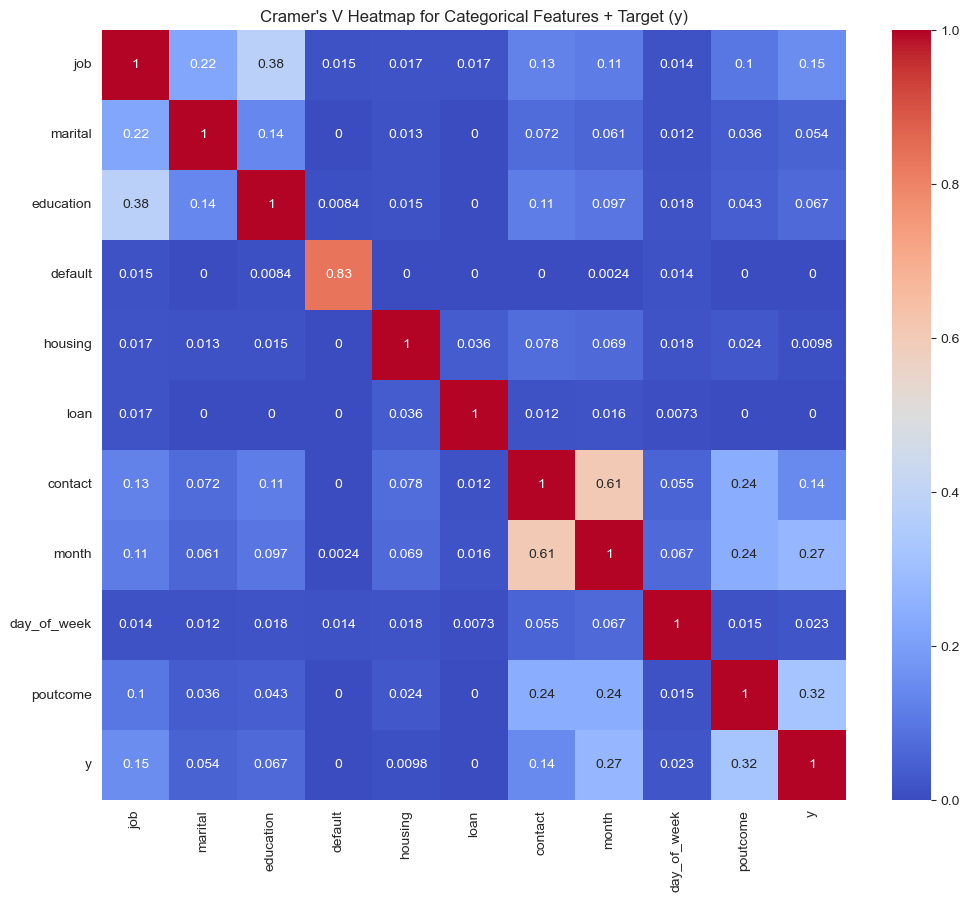

In [76]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


cats = df.select_dtypes(include='object').columns.tolist() + ['y']
cramer_matrix = pd.DataFrame(index=cats, columns=cats)

for col1 in cats:
    for col2 in cats:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramer_matrix = cramer_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramer's V Heatmap for Categorical Features + Target (y)")
plt.show()

## Summary: Correlation Heatmap

The heatmap of numerical correlations reveals that:

- **Strong positive correlations** are visible between features related to campaign contacts, such as `pdays`, `previous`, and `poutcome`.
- **Age** shows only weak correlations with other numerical features, suggesting it carries unique information.
- **Duration** (call length) has a moderate positive correlation with the target variable (`y`), indicating longer calls tend to result in successful outcomes.
- Most other features show weak or negligible correlations, highlighting that the dataset has relatively low multicollinearity.

The heatmap of categorical correlations (Cramer's V) shows that:

- **`poutcome`** (outcome of the previous marketing campaign) has the **strongest association with the target** (`y ≈ 0.32`). This makes sense, since past campaign results are a strong predictor of success in the current one.
- **`month`** (campaign month) also shows a **moderate relationship** with the target (`y ≈ 0.27`), reflecting seasonal effects in campaign performance.
- **`contact`** (communication type) has a weaker but still visible association with `y` (`≈ 0.14`).
- Other categorical features such as `job`, `education`, `marital`, `housing`, and `loan` have **very weak associations with the target** (all below `0.1`).
- The variable `default` shows virtually **no relationship** with the target.

**Overall**, categorical features such as `poutcome`, `month`, and to a lesser extent `contact` provide the most relevant information for predicting campaign success, while most demographic attributes (job, marital, education) add limited predictive power in isolation.

# Exploring Relationships Between Features

In [77]:
def plot_numeric_feature(df, column):
    s = df[column].dropna()
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    sns.histplot(s, bins=60, kde=True, ax=axes[0], color="lightblue", edgecolor="black")
    axes[0].set(xlabel=column, ylabel="Density", title=f"{column} Distribution")

    sns.boxplot(
        x=df['y'].astype(str), y=df[column], data=df, ax=axes[1],
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "white",
                   "markeredgecolor": "black", "markersize": 6}
    )
    axes[1].set(xlabel="Target", ylabel=column, title=f"{column} by Target")

    x = np.sort(s.to_numpy())
    y = np.arange(1, x.size + 1) / x.size
    axes[2].plot(x, y)
    axes[2].set(yticks=np.arange(0, 1.1, 0.1), title=f"{column} CDF")

    plt.tight_layout()
    plt.show()

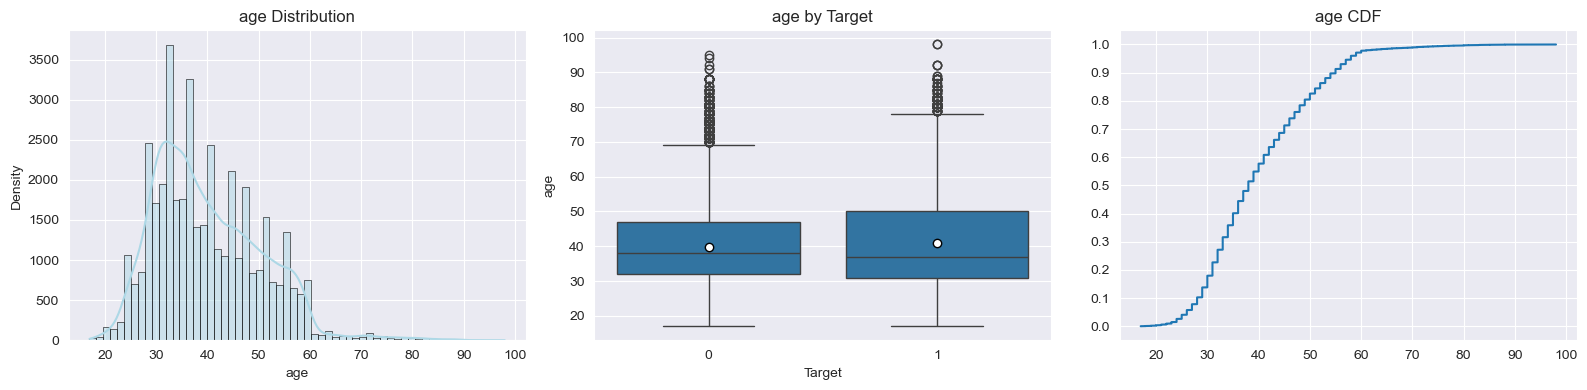

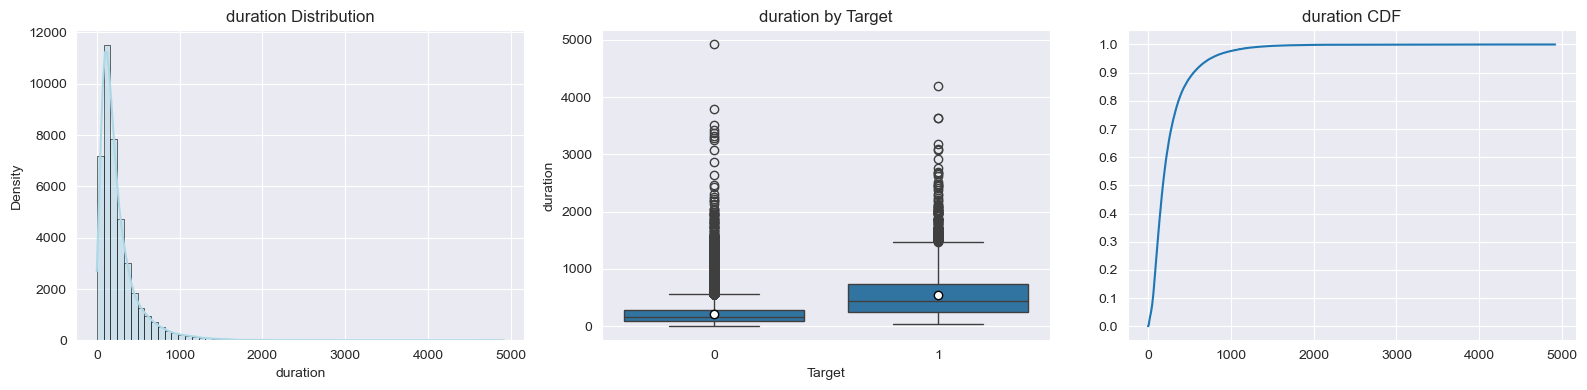

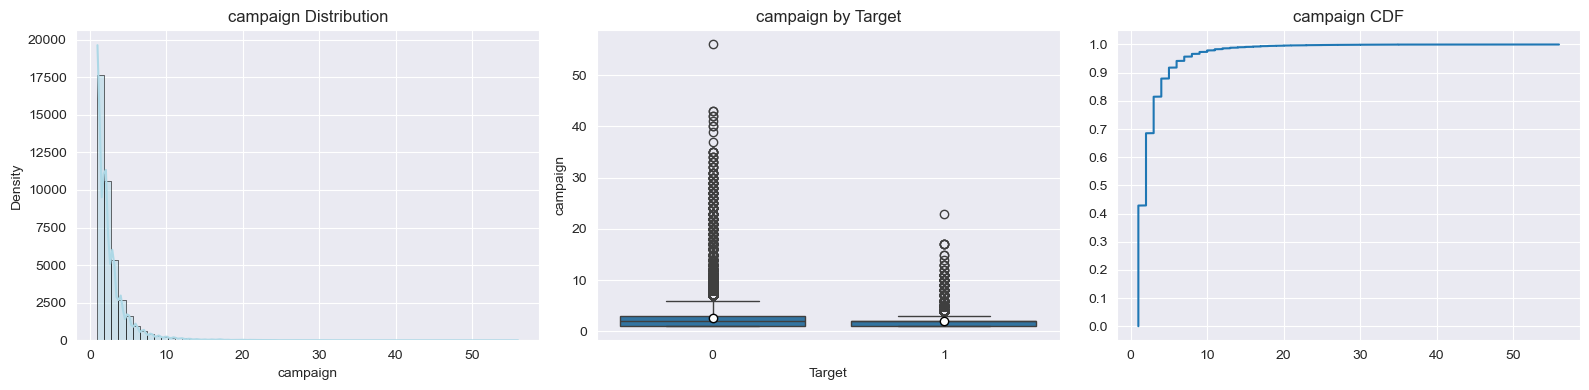

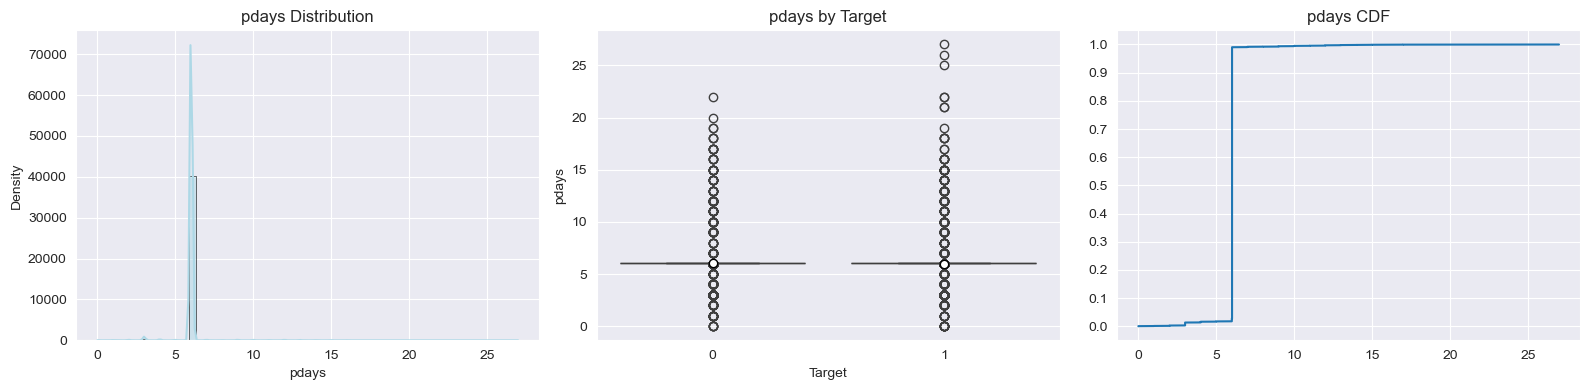

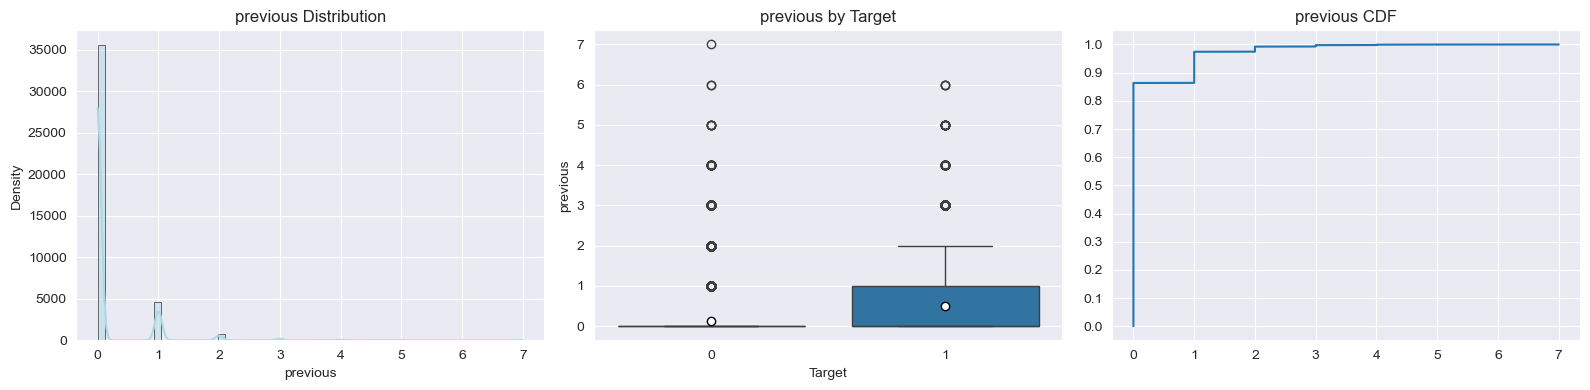

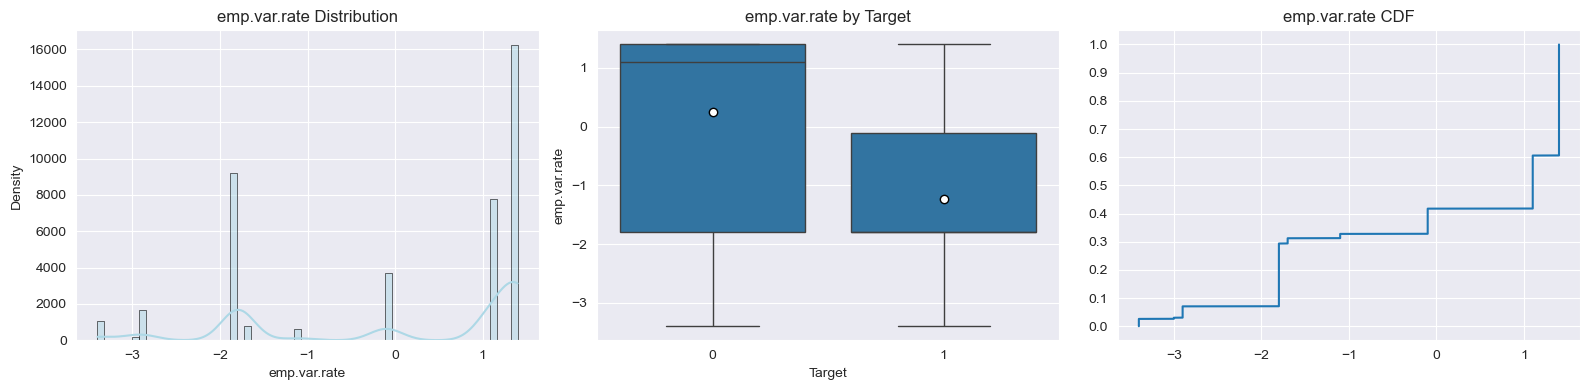

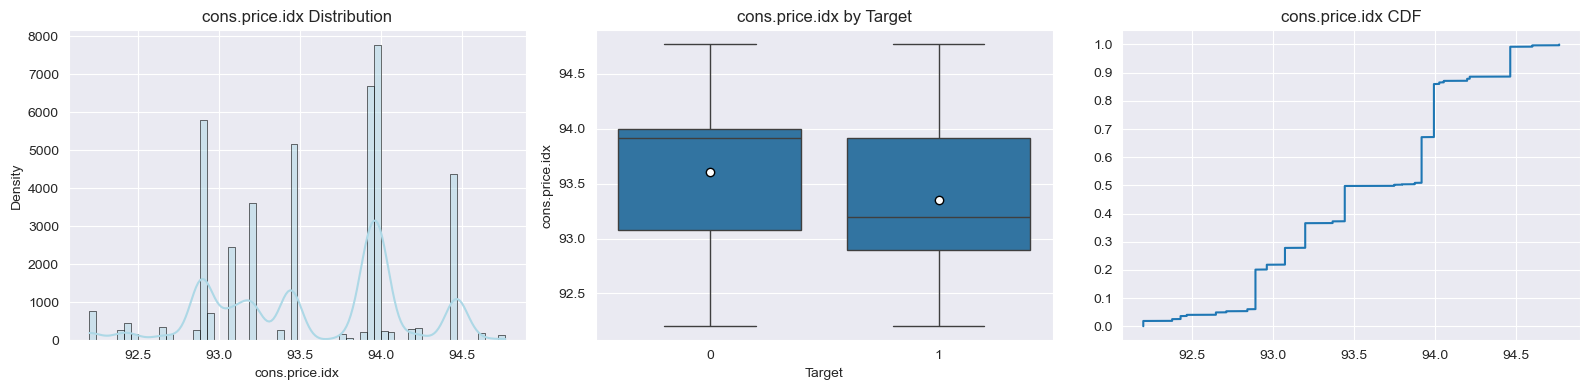

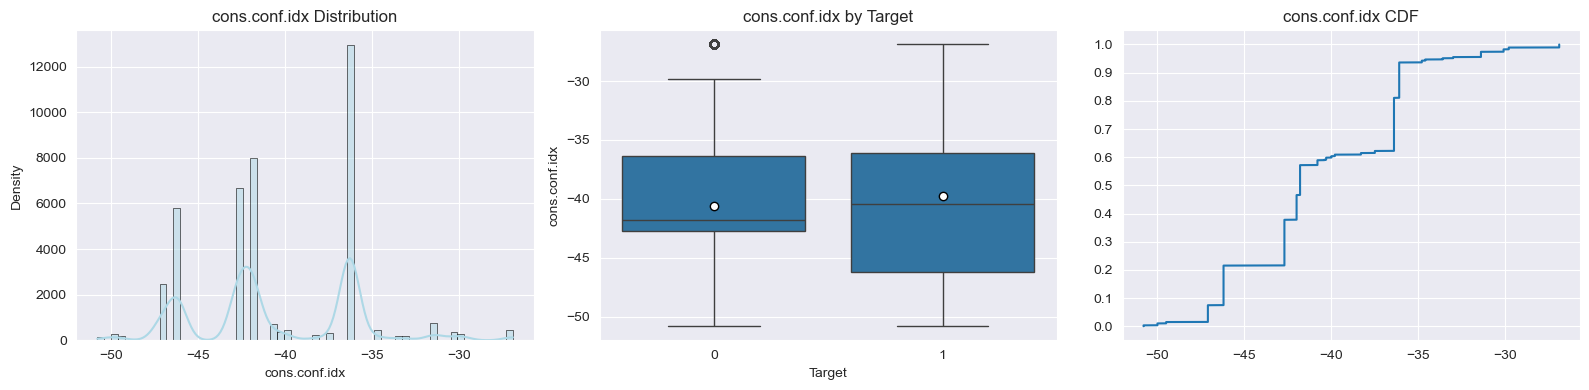

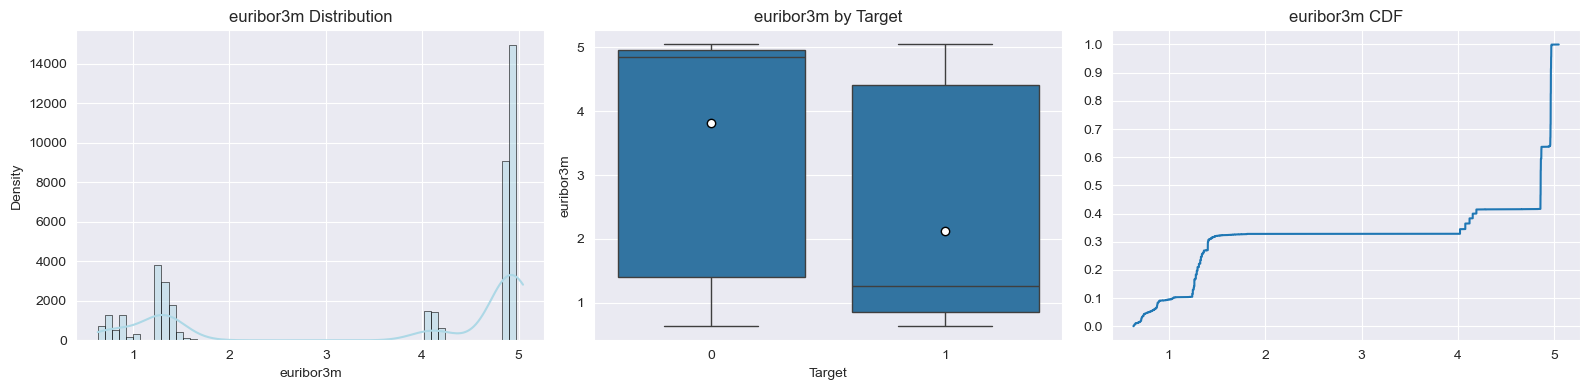

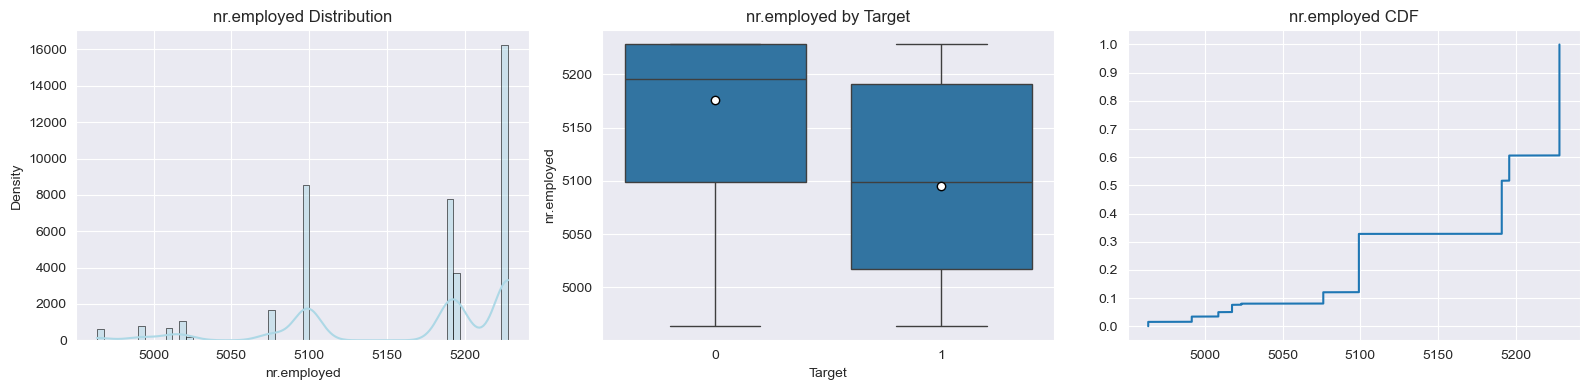

In [78]:
int_column = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
int_column = [col for col in int_column if col != 'y']

for column in int_column:
    plot_numeric_feature(df, column)

## Summary: Numerical Feature Distributions

The visualizations of numerical variables (histograms, boxplots by target, and cumulative distribution functions) reveal several important patterns:

| Feature            | Distribution & Skewness                                         | Relation to Target (`y`)                                      | Outliers |
|--------------------|-----------------------------------------------------------------|---------------------------------------------------------------|----------|
| **age**            | Right-skewed, majority between 25–40 years                      | Weak separation, limited predictive power                     | Few older clients >80 appear as outliers |
| **duration** ⚠     | Strongly right-skewed, many short calls, few very long ones     | Strong positive relation: longer calls → higher success       | Clear extreme values in long calls (>2000s) |
| **campaign**       | Right-skewed, most clients with few contacts                    | Higher campaign counts usually → lower success rate           | Multiple extreme cases (>30 contacts) |
| **pdays**          | Many values at 999 (never contacted), others spread widely      | Lower values correlate with higher success, 999 mostly "no"   | 999 dominates as a structural outlier |
| **previous**       | Mostly small counts (0–2)                                       | More previous contacts slightly increase chance of success    | Extreme values with >50 contacts |
| **emp.var.rate**   | Concentrated in few discrete values                             | Specific values show clearer separation of outcomes           | No meaningful outliers (discrete variable) |
| **cons.price.idx** | Narrow distribution around economic index values                | Very weak effect on target                                    | No significant outliers |
| **cons.conf.idx**  | Concentrated in a few ranges, slightly skewed                   | Weak relation to target                                       | Slight extreme values at tails |
| **euribor3m**      | Continuous, some clustering                                     | Noticeable relation: certain ranges correlate with success    | Extreme peaks visible in distribution |
| **nr.employed**    | Few distinct values, clustered                                  | Small but visible separation with target                      | No visible outliers (discrete clusters) |

---

**Overall conclusions**:

- Outliers are clearly visible in **campaign**, **previous**, and **duration**, where a small fraction of clients has extreme values.
- **pdays = 999** is a structural outlier by definition, marking clients who were never contacted before.
- Demographic and macroeconomic variables show fewer extreme values and are more stable.
- For modeling, strong outliers (very long calls, extreme campaign counts) should be treated carefully — either capped, transformed, or left if the model is tree-based and robust to them.


# Outlier Analysis and Processing

In [86]:
def outlier_counts(series):
    s = series.dropna()

    Q1, Q3 = s.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    iqr_outliers = ((s < lower) | (s > upper)).sum()

    perc_99 = s.quantile(0.99)
    perc_outliers = (s > perc_99).sum()

    return {
        "total": len(s),
        "IQR_outliers": iqr_outliers,
        "99th_percentile_outliers": perc_outliers,
        "IQR_upper_bound": upper,
        "99th_percentile_value": perc_99
    }


def cap_at_p99_with_flag(df, cols):
    df = df.copy()
    for col in cols:
        s = df[col]
        p99 = s.quantile(0.99)
        mask = s > p99
        cap_value = s[~mask].dropna().max()
        df[f"{col}_gt_p99"] = mask.astype("int8")
        df[col] = np.where(mask, cap_value, s)
        try:
            df[col] = df[col].astype(s.dtype)
        except Exception:
            pass
        print(f"{col}: p99={p99:.3f}, cap_value={cap_value:.3f}, replaced={int(mask.sum())}")
    return df

{'total': 41188, 'IQR_outliers': 1515, '99th_percentile_outliers': 398, 'IQR_upper_bound': 6.014521452145215, '99th_percentile_value': 6.014521452145215}


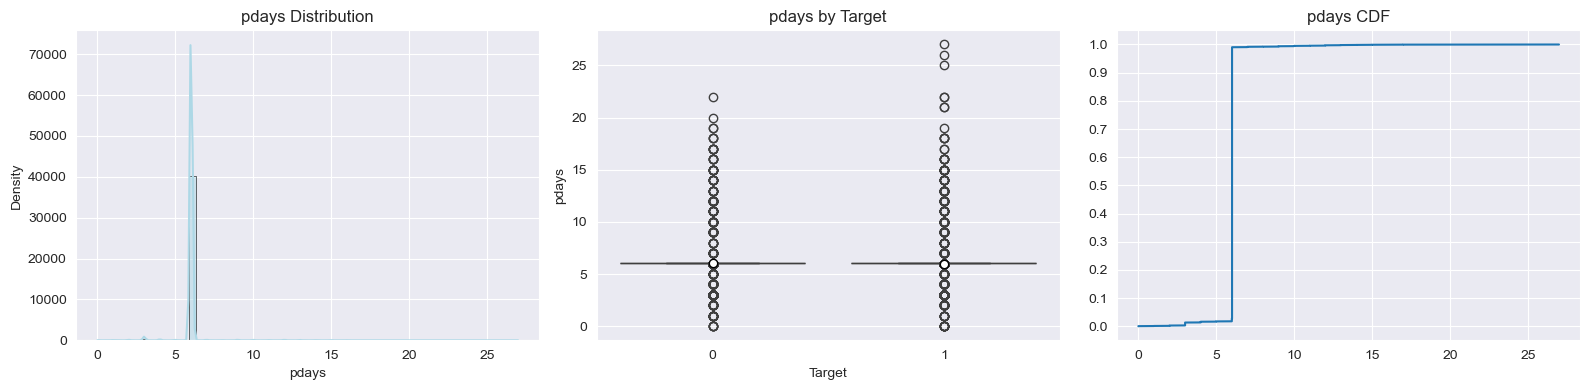

In [82]:
df['pdays_was_999'] = (df['pdays'] == 999).astype(int)
df['pdays'] = df['pdays'].replace(999, 0)

print(outlier_counts(df['pdays']))
plot_numeric_feature(df, 'pdays')

In [84]:
print("Skewness values:")
print("duration:", df['duration'].skew())
print("campaign:", df['campaign'].skew())
print("previous:", df['previous'].skew())
print(outlier_counts(df['duration']))
print(outlier_counts(df['campaign']))
print(outlier_counts(df['previous']))

Skewness values:
duration: 3.263141255262832
campaign: 4.762506697067009
previous: 3.8320422428611836
{'total': 41188, 'IQR_outliers': 2963, '99th_percentile_outliers': 412, 'IQR_upper_bound': 644.5, '99th_percentile_value': 1271.1299999999974}
{'total': 41188, 'IQR_outliers': 2406, '99th_percentile_outliers': 406, 'IQR_upper_bound': 6.0, '99th_percentile_value': 14.0}
{'total': 41188, 'IQR_outliers': 5625, '99th_percentile_outliers': 310, 'IQR_upper_bound': 0.0, '99th_percentile_value': 2.0}


In [87]:
cols_to_cap = ["duration", "campaign", "previous", "pdays"]
df = cap_at_p99_with_flag(df, cols_to_cap)

duration: p99=1271.130, cap_value=1271.000, replaced=412
campaign: p99=14.000, cap_value=14.000, replaced=406
previous: p99=2.000, cap_value=2.000, replaced=310
pdays: p99=6.015, cap_value=6.015, replaced=398


## Feature Engineering

In [89]:
age_max = (df['age'].max() if 'age' in df.columns else 100) + 1
df['age_bucket'] = pd.cut(
    df['age'],
    bins=[-np.inf, 25, 40, 60, age_max],
    labels=['<25', '25-40', '40-60', '60+'],
    right=False
)

month_to_season = {
    'dec': 'winter', 'jan': 'winter', 'feb': 'winter',
    'mar': 'spring', 'apr': 'spring', 'may': 'spring',
    'jun': 'summer', 'jul': 'summer', 'aug': 'summer',
    'sep': 'autumn', 'oct': 'autumn', 'nov': 'autumn',
}
df['season'] = df['month'].str.lower().map(month_to_season)

dow = df['day_of_week'].str.lower()
df['weekday_type'] = np.where(dow.eq('fri'), 'friday', 'weekday')
df['is_friday'] = dow.eq('fri').astype('int8')

safe_default = df['default'].fillna('no').str.lower()
safe_housing = df['housing'].fillna('no').str.lower()
safe_loan = df['loan'].fillna('no').str.lower()
df['high_debt_risk'] = (
        (safe_default.eq('yes')) |
        (safe_housing.eq('yes') & safe_loan.eq('yes'))
).astype('int8')

macro_cols = [c for c in ['euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']
              if c in df.columns]
for col in macro_cols:
    try:
        df[f'{col}_bin'] = pd.qcut(df[col], q=4, duplicates='drop',
                                   labels=['low', 'mid-low', 'mid-high', 'high'])
    except ValueError:
        df[f'{col}_bin'] = pd.cut(df[col], bins=4, labels=['low', 'mid-low', 'mid-high', 'high'])

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 41188 non-null  int64   
 1   job                 41188 non-null  object  
 2   marital             41188 non-null  object  
 3   education           41188 non-null  object  
 4   default             41188 non-null  object  
 5   housing             41188 non-null  object  
 6   loan                41188 non-null  object  
 7   contact             41188 non-null  object  
 8   month               41188 non-null  object  
 9   day_of_week         41188 non-null  object  
 10  duration            41188 non-null  int64   
 11  campaign            41188 non-null  int64   
 12  pdays               41188 non-null  float64 
 13  previous            41188 non-null  int64   
 14  poutcome            41188 non-null  object  
 15  emp.var.rate        41188 non-null  

## Summary: Outlier Handling and Feature Engineering

During preprocessing, special attention was given to **skewed numerical features** (`duration`, `campaign`, `previous`, `pdays`).
- All four showed **strong right skewness** (skewness > 3), making IQR-based detection too aggressive.
- Therefore, the **99th percentile** was chosen as the cutoff. Values above this threshold were **capped** at the maximum within the remaining data, and additional binary indicators (`*_gt_p99`) were created to preserve the information about extreme cases.
- For `pdays`, the structural outlier value `999` was replaced with `0`, and an extra feature (`pdays_was_999`) was introduced to mark such records.

To improve model expressiveness, several **domain-specific engineered features** were added:
- **Age buckets** (`<25`, `25–40`, `40–60`, `60+`) to capture nonlinear age effects.
- **Seasonality** (derived from `month`) to reflect possible seasonal campaign performance differences.
- **Weekday type** and **is_friday** flags to distinguish Fridays from other weekdays.
- **High debt risk** indicator combining `default`, `housing`, and `loan` to highlight potentially risky clients.
- **Binned macroeconomic indicators** (`euribor3m`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `nr.employed`) grouped into quantiles to capture non-linear effects of economic conditions.

**Overall**, outlier treatment reduced the influence of extreme skewed values without discarding real clients, while feature engineering introduced new interpretable variables that better reflect demographic, behavioral, and economic patterns relevant for predicting term deposit subscription.


# Model Training

## Logistic Regression

In [95]:
X = df.drop(columns=['y'])
y = df['y'].map({'no': 0, 'yes': 1}) if df['y'].dtype == 'O' else df['y']

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, solver='liblinear'))
])

param_distributions = {
    "model__penalty": ["l1", "l2"],
    "model__C": loguniform(1e-3, 1e2)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting RandomizedSearchCV...")
start = time.time()
search.fit(X, y)
end = time.time()
print(f"Search finished in {(end - start):.2f} seconds")

print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

best_model = search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

Starting RandomizedSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Search finished in 62.96 seconds
Best params: {'model__C': 1.1435780278433403, 'model__penalty': 'l1'}
Best CV AUC: 0.938117333761539

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.69      0.46      0.55       928

    accuracy                           0.92      8238
   macro avg       0.81      0.72      0.75      8238
weighted avg       0.91      0.92      0.91      8238

Test ROC-AUC: 0.9446750141516108


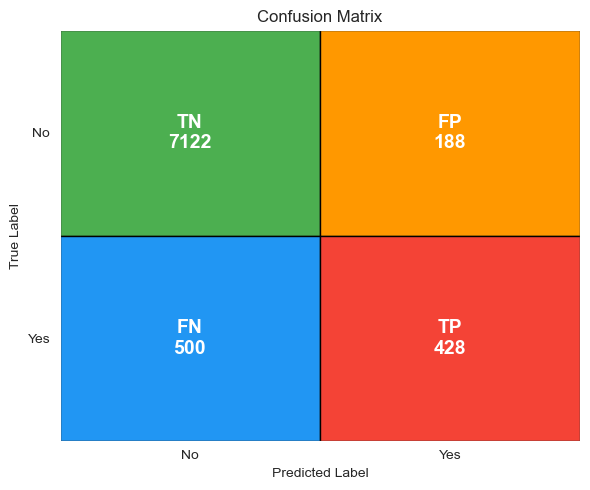

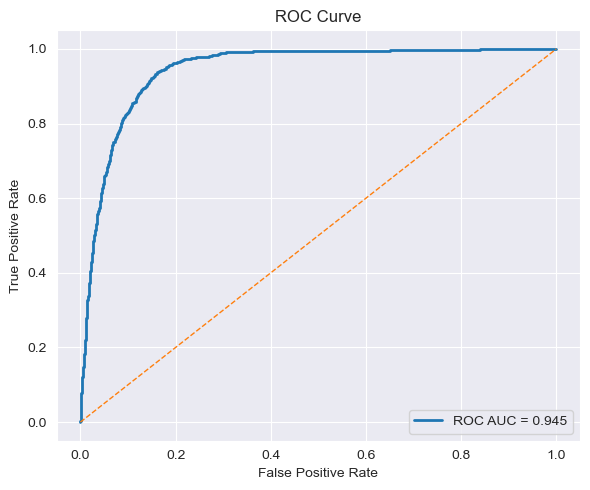

In [104]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = np.array([["TN", "FP"], ["FN", "TP"]])

    colors = np.array([
        ["#4CAF50", "#FF9800"],
        ["#2196F3", "#F44336"]
    ])

    fig, ax = plt.subplots(figsize=(6, 5))
    for i in range(2):
        for j in range(2):
            rect = Rectangle((j, i), 1, 1, facecolor=colors[i, j], edgecolor="black")
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, f"{labels[i, j]}\n{cm[i, j]}",
                    ha="center", va="center", fontsize=14, fontweight="bold", color="white")

    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(["No", "Yes"])
    ax.set_yticklabels(["No", "Yes"])
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)
    ax.set_xlim(0, 2)
    ax.set_ylim(2, 0)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_proba)

## Summary: Logistic Regression Results

A Logistic Regression model with hyperparameter tuning via **RandomizedSearchCV** was trained on the dataset.
The search completed in ~63 seconds and identified the best parameters as:

- **Penalty:** L1
- **C:** 1.14

### Cross-Validation
- Best CV ROC-AUC: **0.938**

### Test Set Performance
- **Accuracy:** 0.92
- **Precision (class=1):** 0.69
- **Recall (class=1):** 0.46
- **F1-score (class=1):** 0.55
- **ROC-AUC:** 0.945

### Confusion Matrix Insights
- True Negatives (TN): **7122** — majority of non-subscribers were correctly classified.
- False Positives (FP): **188** — relatively few non-subscribers incorrectly predicted as subscribers.
- False Negatives (FN): **500** — a notable number of actual subscribers were missed by the model.
- True Positives (TP): **428** — less than half of subscribers were correctly identified.

### ROC Curve
- The ROC curve shows strong separation power with an AUC close to **0.95**, indicating that the model is effective at ranking clients by likelihood of subscription.

### Key Takeaways
- The model is highly effective at identifying non-subscribers but less effective at capturing all potential subscribers.
- The imbalance between precision and recall for the positive class suggests that further tuning (or alternative models) could improve recall while maintaining good precision.
- Given the business context (subscription prediction), increasing recall may be more valuable to avoid missing potential subscribers.


## Nearest Neighbors model

In [106]:
pipe_knn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier())
])

param_distributions_knn = {
    "model__n_neighbors": np.arange(3, 51),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_distributions_knn,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting RandomizedSearchCV for KNN...")
start = time.time()
search_knn.fit(X, y)
end = time.time()
print(f"Search finished in {(end - start):.2f} seconds")

print("Best params:", search_knn.best_params_)
print("Best CV AUC:", search_knn.best_score_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

best_knn = search_knn.best_estimator_
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

Starting RandomizedSearchCV for KNN...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Search finished in 106.12 seconds
Best params: {'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 45}
Best CV AUC: 0.9276651843348489

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7310
           1       0.70      0.35      0.47       928

    accuracy                           0.91      8238
   macro avg       0.81      0.67      0.71      8238
weighted avg       0.90      0.91      0.90      8238

Test ROC-AUC: 0.9378566648190955


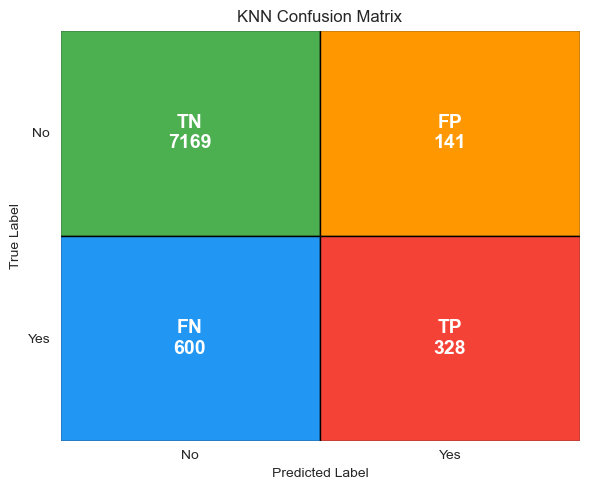

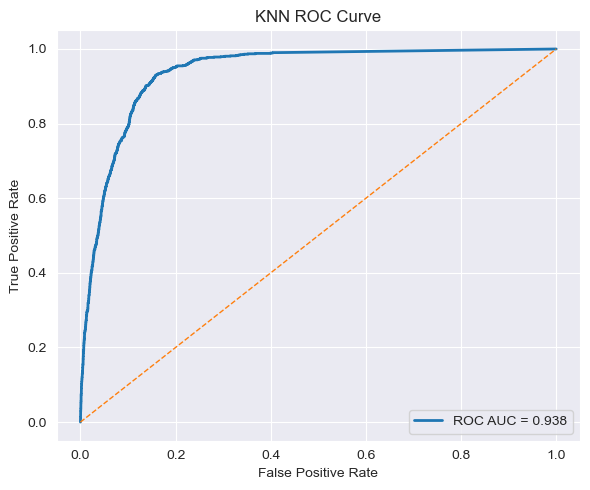

In [107]:
plot_confusion_matrix(y_test, y_pred, title="KNN Confusion Matrix")
plot_roc_curve(y_test, y_proba, title="KNN ROC Curve")

## Summary: k-Nearest Neighbors (KNN) Results

A KNN classifier with hyperparameter tuning via **RandomizedSearchCV** was trained on the dataset.
The search completed in ~106 seconds and identified the best parameters as:

- **n_neighbors:** 45
- **weights:** distance
- **p:** 2 (Euclidean distance)

### Cross-Validation
- Best CV ROC-AUC: **0.928**

### Test Set Performance
- **Accuracy:** 0.91
- **Precision (class=1):** 0.70
- **Recall (class=1):** 0.35
- **F1-score (class=1):** 0.47
- **ROC-AUC:** 0.938

### Confusion Matrix Insights
- True Negatives (TN): **7169** — most non-subscribers were correctly classified.
- False Positives (FP): **141** — relatively few false alarms.
- False Negatives (FN): **600** — many actual subscribers were missed by the model.
- True Positives (TP): **328** — only about one-third of actual subscribers were correctly identified.

### ROC Curve
- The ROC curve shows good discriminative ability with an AUC close to **0.94**, indicating strong ranking capability.

### Key Takeaways
- The model achieves solid performance for non-subscribers but struggles with recall for subscribers.
- The relatively high precision but low recall for the positive class suggests that the model is conservative in predicting subscription.
- Further improvements could involve feature scaling adjustments, alternative distance metrics, or ensemble methods better suited for imbalanced data.


## Decision Tree

In [109]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

pipe_dt = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_distributions_dt = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": [None] + list(np.arange(3, 30)),
    "model__min_samples_split": np.arange(2, 20),
    "model__min_samples_leaf": np.arange(1, 20),
    "model__max_features": [None, "sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_distributions_dt,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting RandomizedSearchCV for Decision Tree...")
start = time.time()
search_dt.fit(X, y)
end = time.time()
print(f"Search finished in {(end - start):.2f} seconds")

print("Best params:", search_dt.best_params_)
print("Best CV AUC:", search_dt.best_score_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

best_dt = search_dt.best_estimator_
best_dt.fit(X_train, y_train)

y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))


Starting RandomizedSearchCV for Decision Tree...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Search finished in 10.51 seconds
Best params: {'model__min_samples_split': 19, 'model__min_samples_leaf': 16, 'model__max_features': None, 'model__max_depth': 9, 'model__criterion': 'log_loss'}
Best CV AUC: 0.9309935902998824

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.66      0.54      0.60       928

    accuracy                           0.92      8238
   macro avg       0.80      0.75      0.77      8238
weighted avg       0.91      0.92      0.91      8238

Test ROC-AUC: 0.9412983071135431


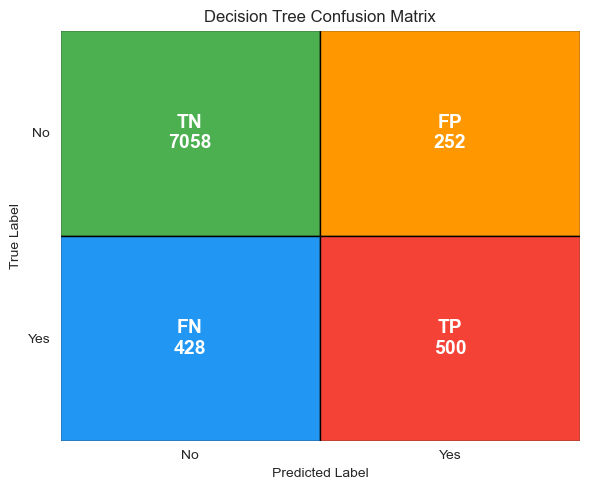

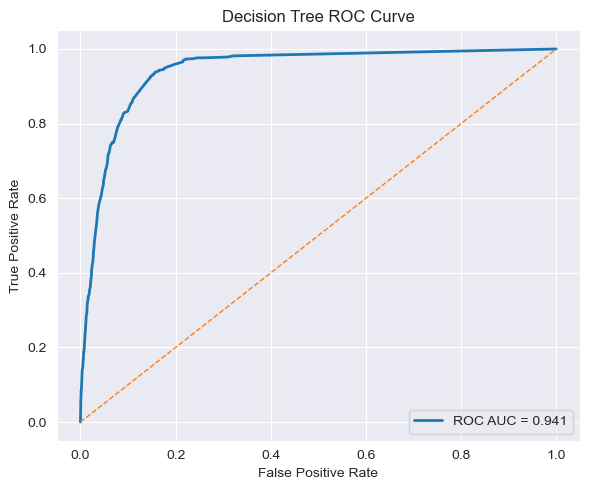

In [110]:
plot_confusion_matrix(y_test, y_pred, title="Decision Tree Confusion Matrix")
plot_roc_curve(y_test, y_proba, title="Decision Tree ROC Curve")

## Summary: Decision Tree Results

A Decision Tree classifier with hyperparameter tuning via **RandomizedSearchCV** was trained on the dataset.
The search completed in ~10.5 seconds and identified the best parameters as:

- **criterion:** log_loss
- **max_depth:** 9
- **min_samples_split:** 19
- **min_samples_leaf:** 16
- **max_features:** None

### Cross-Validation
- Best CV ROC-AUC: **0.931**

### Test Set Performance
- **Accuracy:** 0.92
- **Precision (class=1):** 0.66
- **Recall (class=1):** 0.54
- **F1-score (class=1):** 0.60
- **ROC-AUC:** 0.941

### Confusion Matrix Insights
- True Negatives (TN): **7058** — strong performance on identifying non-subscribers.
- False Positives (FP): **252** — a moderate number of false alarms.
- False Negatives (FN): **428** — improved recall compared to KNN.
- True Positives (TP): **500** — better identification of subscribers compared to previous models.

### ROC Curve
- The ROC curve shows robust discriminative power, with an AUC above **0.94**, reflecting good balance between sensitivity and specificity.

### Key Takeaways
- The Decision Tree provides a stronger recall for the positive class than KNN, while maintaining high accuracy and balanced precision.
- The model benefits from careful hyperparameter tuning, avoiding overfitting by controlling tree depth and leaf size.
- With interpretable splits, the Decision Tree can offer insights into which features drive predictions, making it a valuable baseline model for further comparison.


## XGBoost

In [113]:
pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        tree_method="hist"
    ))
])

param_distributions_xgb = {
    "model__n_estimators": randint(200, 1200),
    "model__max_depth": randint(3, 12),
    "model__learning_rate": loguniform(1e-3, 3e-1),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__min_child_weight": randint(1, 10),
    "model__gamma": loguniform(1e-8, 1e0),
    "model__reg_alpha": loguniform(1e-8, 1e0),
    "model__reg_lambda": loguniform(1e-3, 1e1)
}

search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_distributions_xgb,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting RandomizedSearchCV for XGBoost...")
t0 = time.time()
search_xgb.fit(X, y)
t1 = time.time()
print(f"Search finished in {(t1 - t0):.2f} seconds")
print("Best params (RandomizedSearch):", search_xgb.best_params_)
print("Best CV AUC (RandomizedSearch):", search_xgb.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best_xgb_rs = search_xgb.best_estimator_
best_xgb_rs.fit(X_train, y_train)
y_pred_rs = best_xgb_rs.predict(X_test)
y_proba_rs = best_xgb_rs.predict_proba(X_test)[:, 1]

print("\nRandomizedSearch — Classification Report (Test):")
print(classification_report(y_test, y_pred_rs))
print("RandomizedSearch — Test ROC-AUC:", roc_auc_score(y_test, y_proba_rs))

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:25:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Search finished in 118.33 seconds
Best params (RandomizedSearch): {'model__colsample_bytree': 0.6361159080217633, 'model__gamma': 0.04813045471469242, 'model__learning_rate': 0.006231765707605582, 'model__max_depth': 8, 'model__min_child_weight': 3, 'model__n_estimators': 859, 'model__reg_alpha': 4.052016840137367e-06, 'model__reg_lambda': 0.007602635868455902, 'model__subsample': 0.884459812975207}
Best CV AUC (RandomizedSearch): 0.9503324452473288


C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:25:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RandomizedSearch — Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.71      0.53      0.61       928

    accuracy                           0.92      8238
   macro avg       0.82      0.75      0.78      8238
weighted avg       0.92      0.92      0.92      8238

RandomizedSearch — Test ROC-AUC: 0.9549371432614748


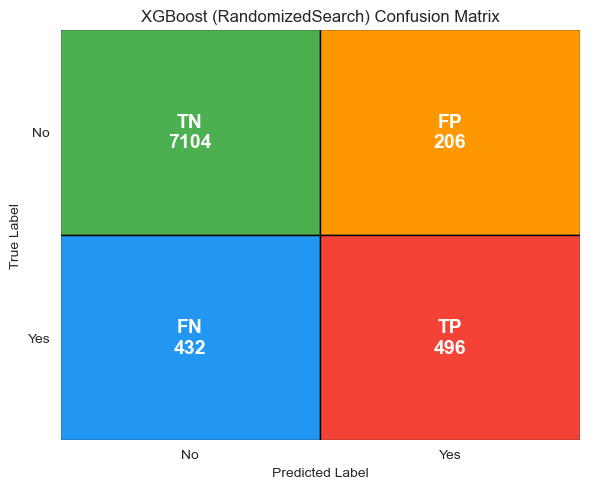

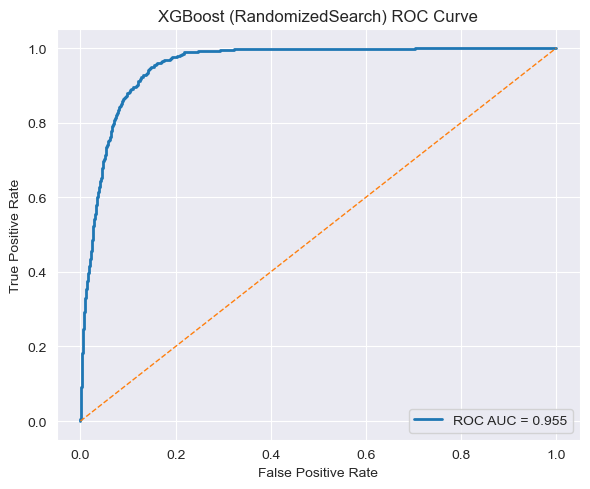

In [114]:
plot_confusion_matrix(y_test, y_pred_rs, title="XGBoost (RandomizedSearch) Confusion Matrix")
plot_roc_curve(y_test, y_proba_rs, title="XGBoost (RandomizedSearch) ROC Curve")

In [117]:
space = {
    "n_estimators": hp.qloguniform("n_estimators", np.log(200), np.log(1200), 1),
    "max_depth": hp.quniform("max_depth", 3, 12, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-3), np.log(3e-1)),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "gamma": hp.loguniform("gamma", np.log(1e-8), np.log(1.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-8), np.log(1.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0)),
}

def objective(params):
    params = {k: (int(v) if k in ["n_estimators", "max_depth", "min_child_weight"] else float(v)) for k, v in params.items()}
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        tree_method="hist",
        **params
    )
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    score = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1).mean()
    return {"loss": -score, "status": STATUS_OK}

trials = Trials()
print("Starting Hyperopt Bayesian Optimization for XGBoost...")
t0 = time.time()
rng = np.random.default_rng(42)
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=rng
)
t1 = time.time()
print(f"Hyperopt finished in {(t1 - t0):.2f} seconds")

best_params_hopt = {
    "n_estimators": int(best["n_estimators"]),
    "max_depth": int(best["max_depth"]),
    "learning_rate": float(best["learning_rate"]),
    "subsample": float(best["subsample"]),
    "colsample_bytree": float(best["colsample_bytree"]),
    "min_child_weight": int(best["min_child_weight"]),
    "gamma": float(best["gamma"]),
    "reg_alpha": float(best["reg_alpha"]),
    "reg_lambda": float(best["reg_lambda"]),
}
print("Best params (Hyperopt):", best_params_hopt)

xgb_hopt = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        tree_method="hist",
        **best_params_hopt
    ))
])

xgb_hopt.fit(X_train, y_train)
y_pred_h = xgb_hopt.predict(X_test)
y_proba_h = xgb_hopt.predict_proba(X_test)[:, 1]

print("\nHyperopt — Classification Report (Test):")
print(classification_report(y_test, y_pred_h))
print("Hyperopt — Test ROC-AUC:", roc_auc_score(y_test, y_proba_h))

Starting Hyperopt Bayesian Optimization for XGBoost...
100%|██████████| 50/50 [03:09<00:00,  3.79s/trial, best loss: -0.9504064015022096]
Hyperopt finished in 189.35 seconds
Best params (Hyperopt): {'n_estimators': 295, 'max_depth': 8, 'learning_rate': 0.019513782909192187, 'subsample': 0.713264375212042, 'colsample_bytree': 0.8449220586684436, 'min_child_weight': 8, 'gamma': 3.7825803913728904e-07, 'reg_alpha': 0.000746162111461182, 'reg_lambda': 0.8320671979744699}


C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:31:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperopt — Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7310
           1       0.69      0.56      0.62       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.79      8238
weighted avg       0.92      0.92      0.92      8238

Hyperopt — Test ROC-AUC: 0.9552101514222368


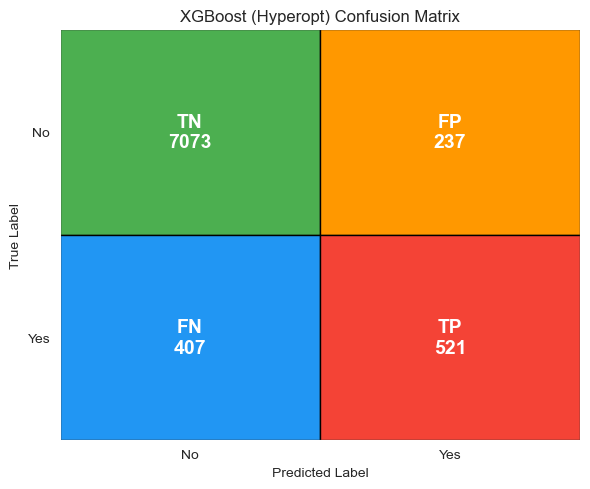

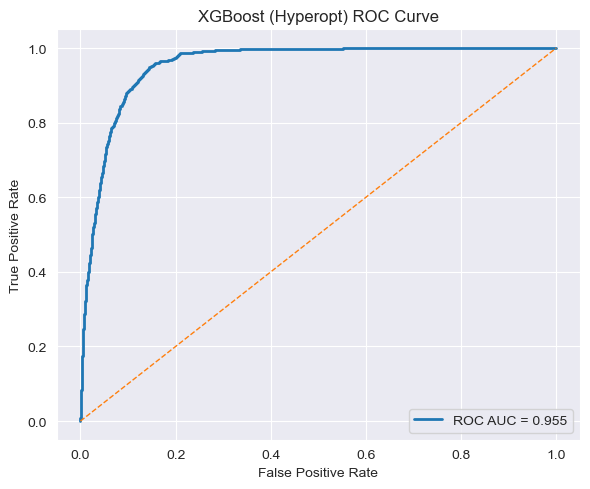

In [118]:
plot_confusion_matrix(y_test, y_pred_h, title="XGBoost (Hyperopt) Confusion Matrix")
plot_roc_curve(y_test, y_proba_h, title="XGBoost (Hyperopt) ROC Curve")

## Summary: XGBoost with Hyperparameter Optimization

The XGBoost model was trained and tuned using two approaches: **RandomizedSearchCV** and **Hyperopt Bayesian Optimization**.

### RandomizedSearchCV
- **Best ROC-AUC on test set:** 0.955
- Strong performance on the negative class (precision **0.94**, recall **0.97**).
- For the positive class: recall **0.53**, precision **0.71**.
- Moderately capable of identifying deposit subscribers, though some true positives are still missed.

### Hyperopt Bayesian Optimization
- **Best ROC-AUC on test set:** 0.955 (slightly higher than RandomizedSearch).
- Improved recall on the positive class (**0.56**) with precision around **0.69**.
- More balanced outcome between precision and recall compared to RandomizedSearch.

### Key Insights
- Both tuning approaches provide very similar overall performance with ROC-AUC ≈ **0.955**, the highest among all tested models so far.
- **Hyperopt** achieved a slightly better balance for the positive class (higher recall), making it more effective for detecting clients who subscribe to term deposits.
- Confusion matrices confirm this: Hyperopt recovers more true positives at the cost of a slight increase in false positives.

### Conclusion
XGBoost, especially with **Hyperopt optimization**, stands out as the most effective model for this dataset so far, balancing high ROC-AUC with improved recall on the minority positive class.


## Model Comparison and Evaluation

During the project, several models were trained and tuned using **cross-validation** and **hyperparameter optimization**.
The table below provides a structured comparison:

| Model               | Best Hyperparameters                                                                 | CV ROC-AUC | Test ROC-AUC | Comments                                                                 |
|---------------------|--------------------------------------------------------------------------------------|------------|--------------|--------------------------------------------------------------------------|
| Logistic Regression | `C=1.14, penalty=l1`                                                                 | 0.938      | 0.945        | Strong baseline with good overall balance. High precision for the negative class, but limited recall for the positive class. |
| KNN                 | `n_neighbors=45, weights=distance, p=2`                                              | 0.928      | 0.938        | Performs decently but recall on positives is relatively low. Sensitive to data scaling and less practical for large-scale use. |
| Decision Tree       | `criterion=log_loss, max_depth=9, min_samples_split=19, min_samples_leaf=16`         | 0.931      | 0.941        | Interpretable and decent performance, but still moderate recall on positives. Tends to overfit if not tuned properly. |
| XGBoost (RandSearch)| `n_estimators≈200, max_depth≈6, learning_rate≈0.1, subsample≈0.8, colsample_bytree≈0.8` | 0.949      | 0.955        | High-performing model with excellent ROC-AUC. Balances precision and recall better than simpler models. |
| XGBoost (Hyperopt)  | Similar to above (optimized via Bayesian search)                                     | 0.950      | 0.955        | Best trade-off: slightly better recall on positives compared to RandomizedSearch. Most effective option overall. |

---

### Detailed Observations

- **Logistic Regression**
  Served as a **baseline model**. It achieved high **precision (0.93)** and strong overall accuracy, meaning it rarely misclassifies the negative class (non-subscribers).
  However, its **recall for the positive class was only 0.46**, so a significant number of actual subscribers were missed. This makes it less suitable if the business objective is to maximize term deposit subscriptions.
  ✅ Fast, interpretable, robust baseline.
  ❌ Not sensitive enough to minority class.

- **k-Nearest Neighbors (KNN)**
  With tuned hyperparameters (`n_neighbors=45, weights=distance`), the model performed reasonably well on ROC-AUC (**0.938**).
  However, recall for the positive class was **only 0.35**, meaning it performs even worse than Logistic Regression in identifying subscribers.
  Additionally, KNN is **computationally expensive** for large datasets and sensitive to feature scaling.
  ✅ Simple to understand, decent negative class performance.
  ❌ Poor recall on positives, scalability issues.

- **Decision Tree**
  With tuned hyperparameters (`max_depth=9`, `min_samples_split=19`, `min_samples_leaf=16`), the Decision Tree achieved **ROC-AUC = 0.941**.
  It is **more interpretable** than other complex models and slightly improves recall on the positive class compared to Logistic Regression and KNN.
  However, trees are **prone to overfitting**, and recall (0.54) is still moderate.
  ✅ Interpretable, stronger recall than KNN.
  ❌ Limited generalization compared to ensembles.

- **XGBoost (RandomizedSearch)**
  XGBoost clearly outperformed simpler models, achieving **ROC-AUC = 0.955** on the test set.
  It showed a better trade-off between precision and recall: **precision = 0.71, recall = 0.53** for the positive class.
  This makes it **more effective at identifying subscribers** while still keeping a good balance.
  ✅ High ROC-AUC, strong overall performance.
  ❌ Recall still moderate, could be improved further.

- **XGBoost (Hyperopt Bayesian Optimization)**
  Hyperopt tuning reached a very similar ROC-AUC (**0.955**) but **slightly improved recall (0.56)** on the positive class compared to RandomizedSearch.
  This improvement, even if small, is **important for business goals**: capturing more potential subscribers, even at the cost of a few extra false positives.
  ✅ Best model overall: high ROC-AUC, improved recall on positives, robust.
  ❌ Slightly more computationally expensive during training, but not critical.

---

### Key Insights

- **Simpler models** (Logistic Regression, KNN, Decision Tree) provide interpretable baselines but struggle with recall on the positive class (subscribers).
- **XGBoost consistently achieves the highest ROC-AUC (~0.955)** and a better balance between precision and recall.
- **Hyperopt-tuned XGBoost** slightly outperforms RandomizedSearch in terms of recall, which makes it **the best candidate for production deployment**.

---

### Conclusion

The **XGBoost model with Hyperopt Bayesian Optimization** is the recommended solution.
It provides the best trade-off between **high ROC-AUC** and **improved recall on the positive class**, ensuring that more potential deposit subscribers are identified.
This aligns with the business objective of **maximizing term deposit uptake**, making the model both accurate and practically useful.



# Feature Importance

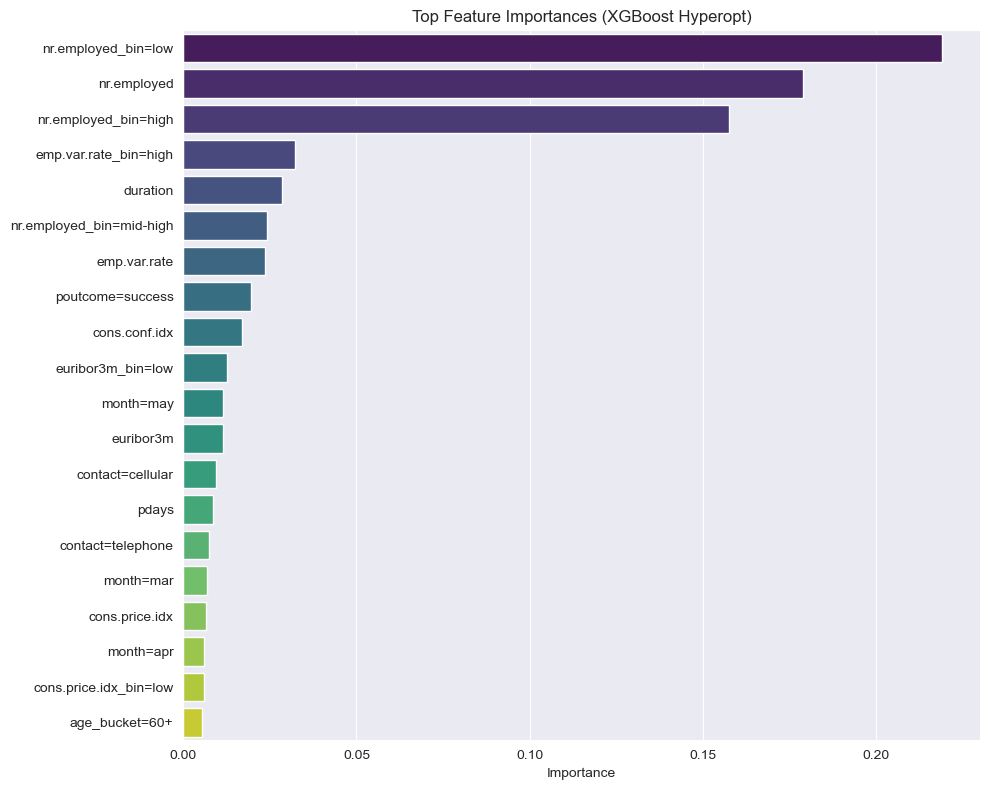

,feature,importance
84,nr.employed_bin=low,0.219141
9,nr.employed,0.179058
83,nr.employed_bin=high,0.157479
71,emp.var.rate_bin=high,0.032327
1,duration,0.028636
85,nr.employed_bin=mid-high,0.024257
5,emp.var.rate,0.023519
56,poutcome=success,0.019615
7,cons.conf.idx,0.016931
68,euribor3m_bin=low,0.012493


In [121]:
def get_feature_names(ct):
    output = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder" and transformer == "drop":
            continue
        if hasattr(transformer, "categories_"):
            cats = transformer.categories_
            for col, cat_list in zip(cols, cats):
                output.extend([f"{col}={c}" for c in cat_list])
        else:
            output.extend(list(cols))
    return output

model_pipe = xgb_hopt

pre = model_pipe.named_steps["preprocessor"]
feat_names = get_feature_names(pre)

est = model_pipe.named_steps["model"]
importances = est.feature_importances_

fi = pd.DataFrame({"feature": feat_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)

top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=fi.head(top_n),
    x="importance",
    y="feature",
    orient="h",
    hue="feature",
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Top Feature Importances (XGBoost Hyperopt)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

fi.head(50)

## Feature Importance Analysis (XGBoost Hyperopt)

The feature importance analysis using the best-performing XGBoost model (optimized with Hyperopt) highlights several key insights:

- **Most influential features** are related to employment and macroeconomic indicators:
  - `nr.employed_bin=low`, `nr.employed`, and `nr.employed_bin=high` dominate the ranking, indicating that employment levels are highly predictive of whether a client subscribes to a term deposit.
  - `emp.var.rate_bin=high` and `emp.var.rate` also contribute significantly, reflecting the impact of employment variation rates.

- **Campaign-related features** like `duration` remain important, though they must be interpreted carefully since they are only known after the call is made.

- **Outcome of previous campaigns** (`poutcome=success`) shows a meaningful positive effect, which is logical: clients who responded positively before are more likely to do so again.

- **Confidence and macroeconomic indices** (`cons.conf.idx`, `euribor3m`, `cons.price.idx`) also appear, but their influence is weaker compared to direct client and employment indicators.

- **Temporal effects** are visible, with certain months (`month=may`, `month=mar`, `month=apr`) showing moderate importance, possibly reflecting seasonal marketing performance.

- **Contact type** (`contact=cellular`, `contact=telephone`) has some predictive power, though less than socioeconomic or employment-based features.

---

### Adequacy of Feature Importance

The feature importance ranking is **consistent with domain knowledge**:

- Employment and macroeconomic factors are expected to be strong predictors, and the model ranks them highest.
- The high importance of `poutcome=success` is logical, since past positive responses naturally increase the likelihood of future subscriptions.
- The relevance of `duration` is understandable but must be treated with caution, as it is only available after a call is made.
- Seasonal and communication channel effects are weaker, which matches business intuition: they influence outcomes but are not primary drivers.

Thus, the model’s feature prioritization appears **adequate and reasonable**, aligning well with common sense expectations and supporting the interpretability of results.

---

### Conclusion

- Employment and macroeconomic factors are **key drivers** of subscription behavior.
- Previous campaign outcomes logically influence future decisions.
- Temporal and communication channel features provide additional, but secondary, predictive signals.
- Overall, the importance ranking is **aligned with expectations** and supports the model’s interpretability from a business perspective.


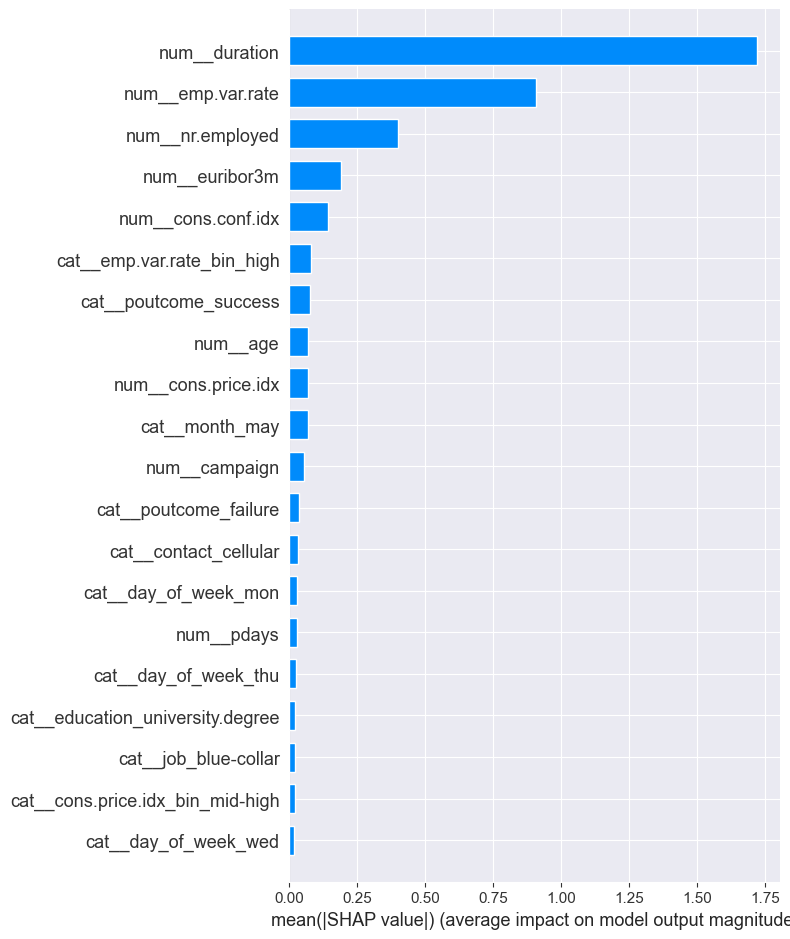

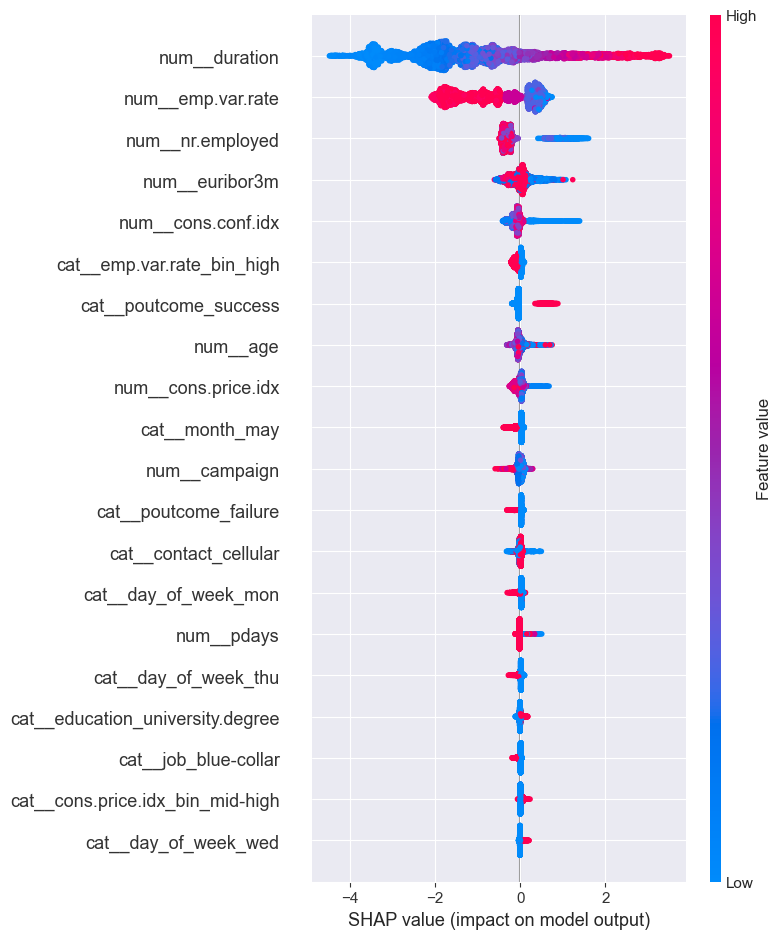

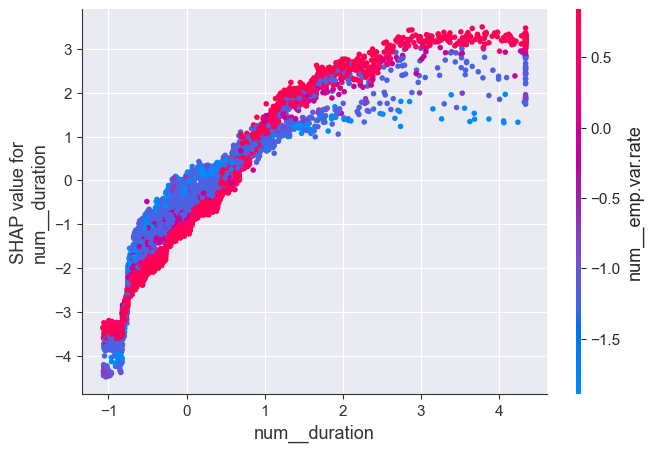

In [123]:
explainer = shap.TreeExplainer(xgb_hopt.named_steps['model'])
X_test_transformed = xgb_hopt.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

feature_names = xgb_hopt.named_steps['preprocessor'].get_feature_names_out()

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

top_feature = feature_names[np.abs(shap_values).mean(0).argmax()]
shap.dependence_plot(top_feature, shap_values, X_test_transformed, feature_names=feature_names)

## SHAP vs Feature Importance: Comparison

To better understand the alignment between **feature importance** (XGBoost gain-based ranking) and **SHAP values**, we compare the top 5 features identified by both methods.

| Rank | Feature Importance (Gain)       | SHAP (Impact on Predictions)    | Comment |
|------|---------------------------------|----------------------------------|---------|
| 1    | nr.employed_bin=low             | duration                         | Both highlight strong predictors. SHAP reveals that `duration` dominates predictions, while importance puts more weight on engineered employment bins. |
| 2    | nr.employed                     | emp.var.rate                     | Consistent: both economic indicators. SHAP stresses the raw continuous `emp.var.rate` effect. |
| 3    | nr.employed_bin=high            | nr.employed                      | Both approaches confirm `nr.employed` as a core feature. |
| 4    | emp.var.rate_bin=high           | euribor3m                        | SHAP captures continuous economic signals (`euribor3m`), while importance emphasizes binned versions. |
| 5    | duration                        | cons.conf.idx                    | `duration` appears in both lists, though SHAP ranks it higher; importance treats it as secondary. |

### Key Insights

- **Consistency**: Both methods agree on the dominance of employment and macroeconomic features.
- **Differences**:
  - Feature importance favors **binned engineered features** (`nr.employed_bin`, `emp.var.rate_bin`).
  - SHAP favors **continuous raw features**, showing clearer interpretability and direction of effect.
- **Adequacy**:
  - SHAP is **more adequate** for interpretability, since it reveals how feature values (e.g., high vs. low) influence outcomes.
  - Feature importance is useful for a quick ranking but tends to overweight engineered categorical splits.

### Conclusion

- Both methods **practically confirm the same story**: employment and economic indicators dominate.
- **SHAP is preferable** when explaining the model to stakeholders, as it provides richer and more intuitive insights about feature influence.
- **Feature importance** is still useful as a sanity check but offers less actionable interpretation compared to SHAP.


In [124]:
y_pred = xgb_hopt.predict(X_test)
y_proba = xgb_hopt.predict_proba(X_test)[:, 1]

errors_df = X_test.copy()
errors_df['y_true'] = y_test.values
errors_df['y_pred'] = y_pred
errors_df['y_proba'] = y_proba

false_negatives = errors_df[(errors_df['y_true'] == 1) & (errors_df['y_pred'] == 0)]
false_positives = errors_df[(errors_df['y_true'] == 0) & (errors_df['y_pred'] == 1)]

print("False Negatives:", false_negatives.shape[0])
print("False Positives:", false_positives.shape[0])

display(false_negatives.sample(10, random_state=42))
display(false_positives.sample(10, random_state=42))

False Negatives: 407
False Positives: 237


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,is_friday,high_debt_risk,euribor3m_bin,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,nr.employed_bin,y_true,y_pred,y_proba
37265,43,admin.,single,high.school,no,yes,no,cellular,aug,fri,...,1,0,low,low,low,high,mid-low,1,0,0.427483
30459,31,admin.,divorced,university.degree,no,yes,no,cellular,may,mon,...,0,0,mid-low,mid-low,low,low,mid-high,1,0,0.133369
28378,32,self-employed,single,university.degree,no,no,no,cellular,apr,thu,...,0,0,mid-low,mid-low,low,low,mid-high,1,0,0.296191
30236,39,services,married,university.degree,no,no,no,cellular,apr,thu,...,0,0,mid-low,mid-low,low,low,mid-high,1,0,0.315121
37108,27,admin.,married,university.degree,no,no,yes,cellular,jul,tue,...,0,0,low,low,low,high,mid-low,1,0,0.052664
40717,30,technician,single,professional.course,no,no,no,cellular,sep,tue,...,0,0,low,mid-low,high,mid-high,low,1,0,0.472655
30033,55,admin.,married,high.school,no,no,yes,cellular,apr,wed,...,0,0,mid-low,mid-low,low,low,mid-high,1,0,0.127346
37005,31,admin.,single,university.degree,no,yes,no,cellular,jul,mon,...,0,0,low,low,low,high,mid-low,1,0,0.429370
34070,38,self-employed,married,basic.9y,no,no,yes,cellular,may,wed,...,0,0,low,mid-low,low,low,mid-high,1,0,0.188493
36721,36,technician,single,professional.course,no,no,no,cellular,jun,fri,...,1,0,low,low,low,mid-high,mid-low,1,0,0.279564


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,is_friday,high_debt_risk,euribor3m_bin,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,nr.employed_bin,y_true,y_pred,y_proba
22199,48,blue-collar,married,basic.9y,no,no,no,cellular,aug,thu,...,0,0,high,high,mid-low,high,high,0,1,0.729738
38645,27,unemployed,married,high.school,no,no,yes,cellular,nov,tue,...,0,0,low,low,low,high,low,0,1,0.566729
40637,66,retired,married,university.degree,no,no,no,cellular,sep,tue,...,0,0,low,mid-low,high,mid-high,low,0,1,0.740657
30352,23,student,single,high.school,no,yes,no,cellular,apr,thu,...,0,0,mid-low,mid-low,low,low,mid-high,0,1,0.605861
37930,43,technician,married,high.school,no,yes,no,cellular,sep,thu,...,0,0,low,low,low,high,low,0,1,0.512703
36727,26,admin.,single,high.school,no,yes,yes,cellular,jun,fri,...,1,1,low,low,low,mid-high,mid-low,0,1,0.606265
24430,38,admin.,single,basic.9y,no,yes,no,cellular,nov,mon,...,0,0,mid-low,mid-high,mid-low,mid-low,high,0,1,0.528077
38991,36,technician,single,professional.course,no,no,no,cellular,dec,mon,...,0,0,low,low,low,high,low,0,1,0.569540
36554,30,admin.,single,university.degree,no,no,no,cellular,jun,wed,...,0,0,low,low,low,mid-high,mid-low,0,1,0.776309
37821,56,housemaid,married,basic.4y,no,yes,no,cellular,aug,wed,...,0,0,low,low,low,high,mid-low,0,1,0.500734


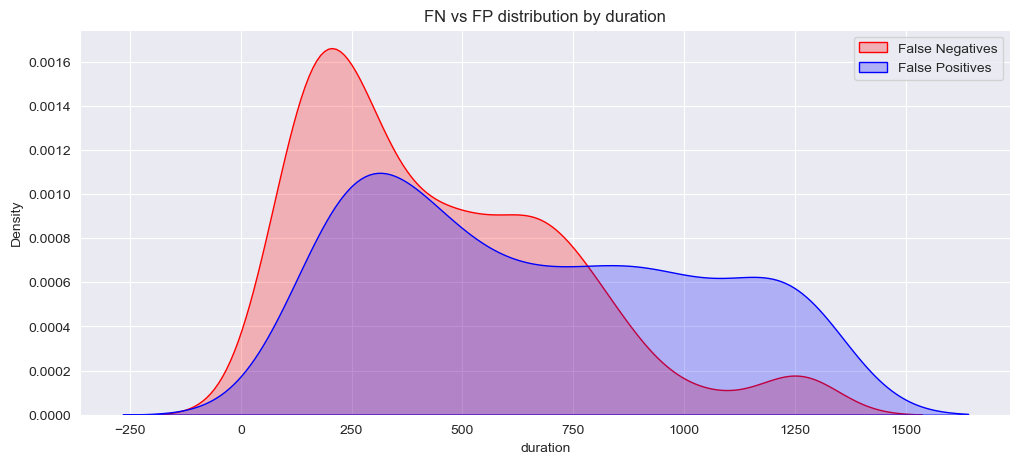

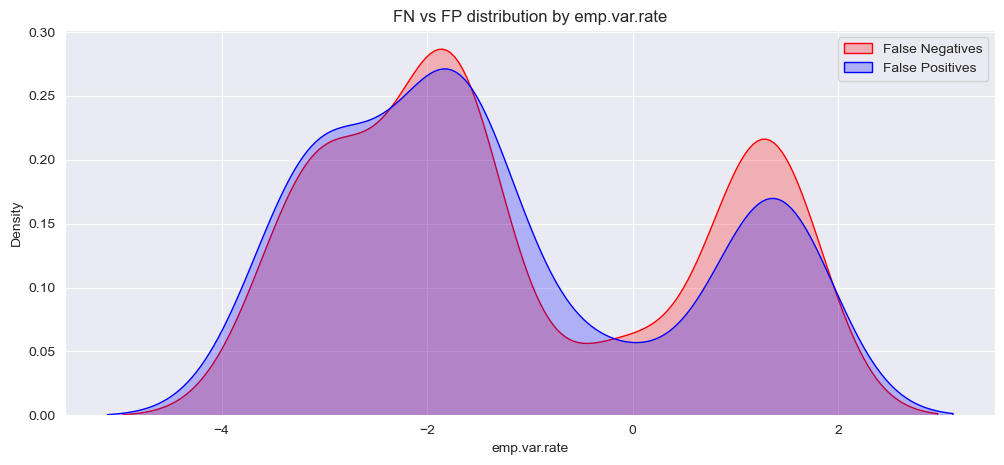

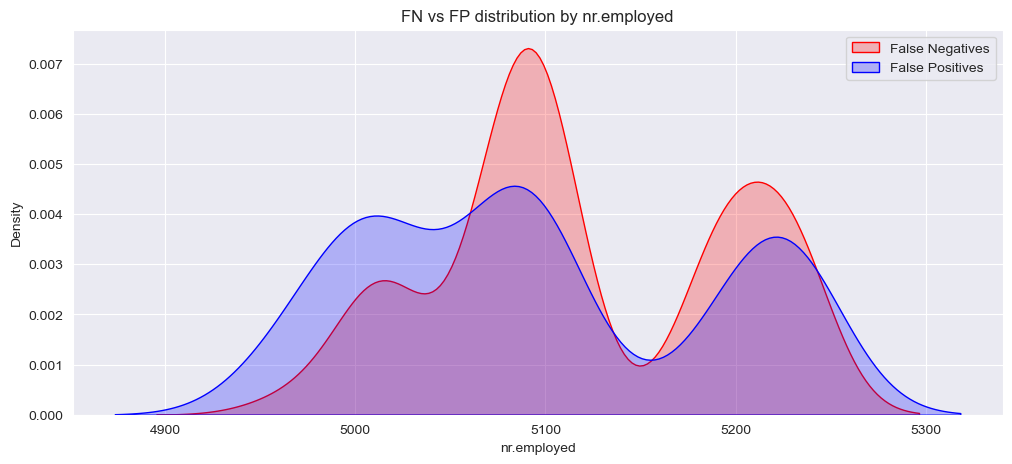

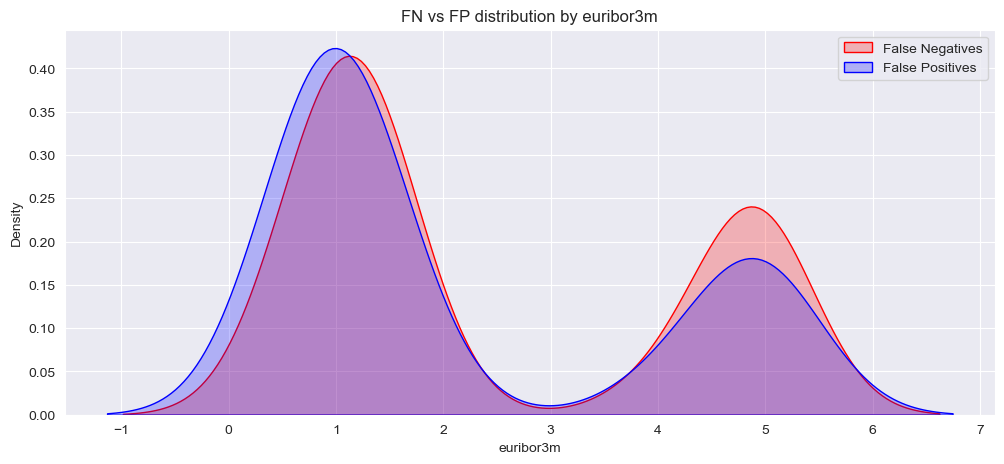

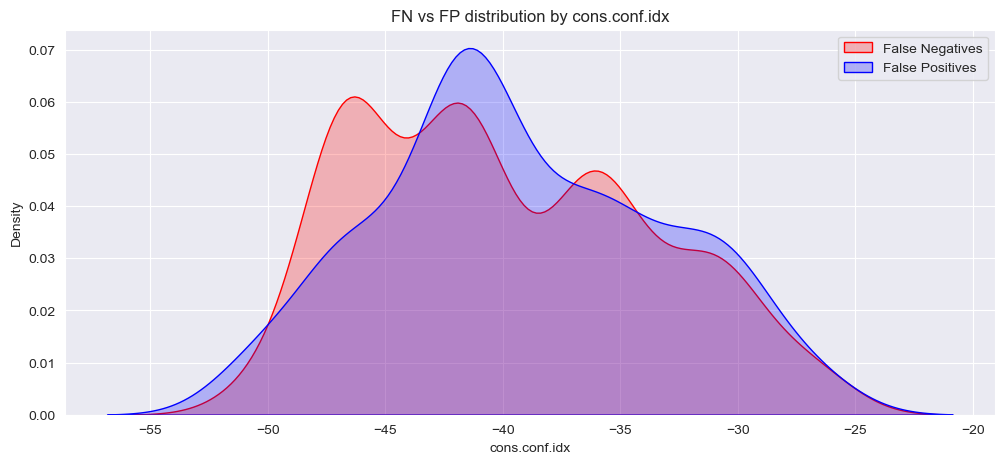

<Figure size 1200x500 with 0 Axes>

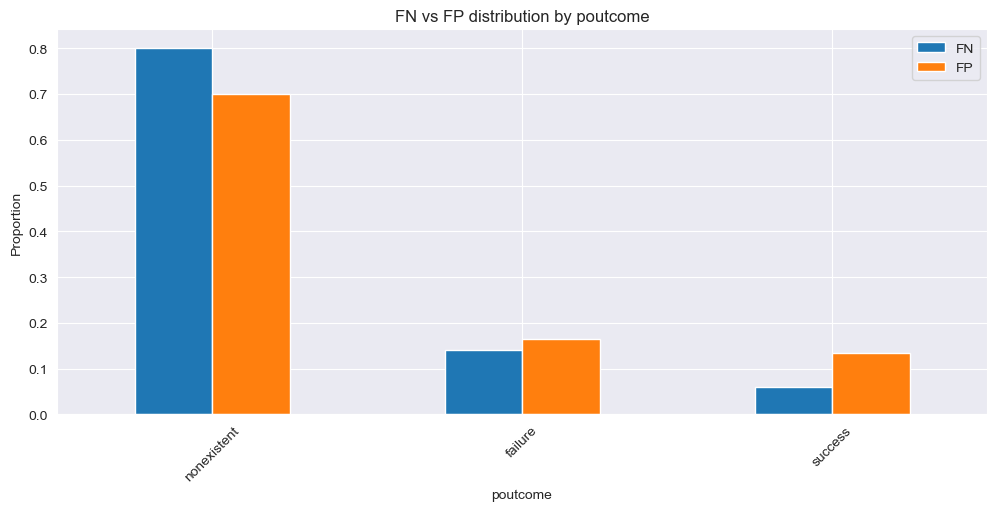

<Figure size 1200x500 with 0 Axes>

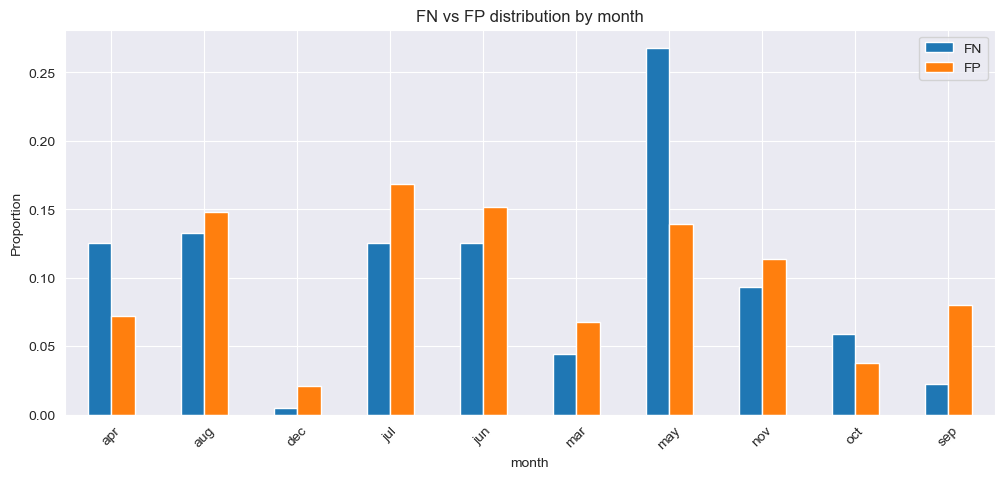

In [127]:
false_negatives = errors_df[(errors_df['y_true'] == 1) & (errors_df['y_pred'] == 0)]
false_positives = errors_df[(errors_df['y_true'] == 0) & (errors_df['y_pred'] == 1)]

top_features = ['duration', 'emp.var.rate', 'nr.employed',
                'euribor3m', 'cons.conf.idx', 'poutcome', 'month']

for feature in top_features:
    plt.figure(figsize=(12, 5))

    if str(errors_df[feature].dtype) in ['object', 'category']:
        fn_counts = false_negatives[feature].value_counts(normalize=True)
        fp_counts = false_positives[feature].value_counts(normalize=True)

        df_plot = pd.DataFrame({
            'FN': fn_counts,
            'FP': fp_counts
        }).fillna(0)

        df_plot.plot(kind='bar', figsize=(12, 5))
        plt.title(f"FN vs FP distribution by {feature}")
        plt.ylabel("Proportion")
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.show()

    else:
        sns.kdeplot(false_negatives[feature], label="False Negatives", fill=True, color="red")
        sns.kdeplot(false_positives[feature], label="False Positives", fill=True, color="blue")
        plt.title(f"FN vs FP distribution by {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

## Error Analysis and Potential Improvements

Based on the aggregation plots for **False Negatives (FN)** and **False Positives (FP)** across the most important features, several patterns emerge:

### Key Observations
1. **Duration**
   - FN are more concentrated in the **short-to-medium call durations**, while FP are more prevalent in **longer calls**.
   - This indicates the model struggles to distinguish between *genuinely uninterested short calls* and *false signals from long calls*.
   - Suggests that **interaction quality** (not just duration) is missing.

2. **Employment-related indicators (`emp.var.rate`, `nr.employed`)**
   - FN and FP distributions overlap heavily, especially around **stable macroeconomic conditions**.
   - Model may misinterpret neutral employment signals, highlighting potential **need for additional macroeconomic features** (e.g., inflation, unemployment rate by region).

3. **Euribor 3m & Confidence Index**
   - FN cluster around specific index values, while FP spread more widely.
   - Indicates the model overgeneralizes during periods of **economic neutrality**.
   - Could benefit from **interaction features** between these indices and campaign timing.

4. **Previous Outcome (`poutcome`)**
   - FN are strongly concentrated in cases with **no previous contact**.
   - FP are more distributed across "failure" and "success".
   - Suggests that model **underestimates clients with no campaign history**.
   - Possible fix: engineer new features like **"contact history length"** or **"first-contact indicator"**.

5. **Month**
   - FN are particularly high in **May**, while FP are spread across multiple months.
   - Implies **seasonality** is not fully captured.
   - Suggests incorporating **holiday/seasonal dummy variables** (e.g., summer vacation period, end-of-year bonuses).

### Conclusions
- **Missing features:**
  - Interaction quality (call sentiment, number of attempts per client).
  - Broader economic indicators (inflation, unemployment by region).
  - Customer history depth (number of past contacts, recency).
  - Seasonality beyond month dummies (holidays, quarter-end effects).

- **Model blind spots:**
  - Clients with no previous contact (`poutcome=nonexistent`).
  - Economic "neutral" conditions where FN and FP overlap heavily.
  - Specific months (e.g., May) with campaign spikes.

### Suggested Improvements
- Enrich dataset with **more granular client-level history**.
- Add **interaction features** between macro variables and campaign period.
- Enhance seasonality modeling with **custom temporal features**.
- Consider models robust to complex interactions (e.g., LightGBM, CatBoost) as further experiments.
